<h1 style="background-color:#4CAF50; color:white; padding:20px; border-radius:10px; text-align:center;">
 🚗 Electric Vehicle Charging Demand Forecasting
</h1>

**Author**: Sherin Samuel  
**Date**: 27 April 2025  
**Project Goal**: Forecast Electric Vehicle (EV) charging demand based on features like weather, time, and traffic.


<h3 style="color:#0b3d91; font-weight:bold;">
Step 1: Import Necessary Libraries and Suppress Warnings to Keep Console Output Clean
</h3>

- **glob, os, sys**: File handling and system operations.
- **pandas, numpy**: Data manipulation and numerical operations.
- **matplotlib, seaborn**: Plotting and visualization.
- **statsmodels**: ARIMA modeling and statistical tests.
- **prophet**: Prophet time-series forecasting.
- **itertools**: Generating parameter combinations for ARIMA grid search.
- **warnings**: Suppress non-critical warnings.

In [54]:
import glob
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind') # Clean style
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools
import prophet
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 2: Define File Paths
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Defines file paths for input data</b> using raw strings (<code>r'...'</code>) to handle Windows path separators.<br>
• <b>weather_pattern</b>: A glob pattern to match multiple weather CSV files (e.g., <i>weather_temperature.csv</i>, <i>weather_humidity.csv</i>).<br>
• <b>ev_file</b>: Path to the EV population dataset.<br>
• <b>traffic_file</b>: Path to the traffic volume dataset for Minneapolis.


In [3]:
# Define file paths (using raw strings for Windows compatibility)
weather_pattern = r'D:\Internship\DataSet\Electrical_vehicle_\weather_*.csv'
ev_file = r'D:\Internship\DataSet\Electrical_vehicle_\Electric_Vehicle_Population_Data.csv'
traffic_file = r'D:\Internship\DataSet\Electrical_vehicle_\Metro_Interstate_Traffic_Volume.csv'

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 3: Collect Weather File Paths 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Uses <code>glob.glob</code></b> to find all files matching the <code>weather_*.csv</code> pattern in the specified directory.<br>
• <b>Prints</b> the number and names of found weather files for debugging.
</h4>

In [4]:
# Step 1: Collect weather file paths
weather_files = glob.glob(weather_pattern)
print(f"Found {len(weather_files)} weather files: {weather_files}")

Found 7 weather files: ['D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_city_attributes.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_description.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_humidity.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_pressure.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_temperature.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_wind_direction.csv', 'D:\\Internship\\DataSet\\Electrical_vehicle_\\weather_wind_speed.csv']


<h3 style="color:#0b3d91; font-weight:bold;">
Step 4: Initialize Weather DataFrame
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Creates</b> an empty <code>Pandas DataFrame</code> as a fallback in case weather files fail to load.<br>
• <b>Ensures</b> <code>weather_data</code> is defined even if no files are found or loading fails.
</h4>

In [5]:
# Initialize variables
weather_data = pd.DataFrame()  # Fallback empty DataFrame

<h3 style="color:#0b3d91; font-weight:bold;">
Step 5: Check and Load Weather Files 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Checks</b> if any weather files were found (<code>weather_files</code> is not empty).<br>
• <b>If files exist</b>, iterates through each file, reads it as a CSV into a DataFrame, and appends it to <code>weather_dfs</code> (a list of DataFrames).<br>
• <b>Includes error handling</b> to catch issues like file corruption or incorrect formats.<br>
• <b>Prints</b> the name, row count, and column count of each successfully loaded file.<br>
• <b>Loads</b> individual weather metric files (e.g., temperature, humidity) into memory.
</h4>

In [6]:
# Step 2: Check if weather files exist
if not weather_files:
    print(f"No weather files found matching pattern: {weather_pattern}")
else:
    # Step 3: Load weather data with error handling
    weather_dfs = []
    for file in weather_files:
        try:
            df = pd.read_csv(file)
            weather_dfs.append(df)
            print(f"Sucessfully Loaded: {os.path.basename(file)} ({len(df)} rows, {len(df.columns)} columns)")
        except Exception as e:
            print(f"Error reading {file}: {e}")

Sucessfully Loaded: weather_city_attributes.csv (36 rows, 4 columns)
Sucessfully Loaded: weather_description.csv (45253 rows, 37 columns)
Sucessfully Loaded: weather_humidity.csv (45253 rows, 37 columns)
Sucessfully Loaded: weather_pressure.csv (45253 rows, 37 columns)
Sucessfully Loaded: weather_temperature.csv (45253 rows, 37 columns)
Sucessfully Loaded: weather_wind_direction.csv (45253 rows, 37 columns)
Sucessfully Loaded: weather_wind_speed.csv (45253 rows, 37 columns)


<h3 style="color:#0b3d91; font-weight:bold;">
Step 6: Concatenate Weather Data 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>If</b> <code>weather_dfs</code> contains DataFrames, concatenates them into a single <code>weather_data</code> DataFrame using <code>pd.concat</code>.<br>
• <b>Ignores</b> original indices (<code>ignore_index=True</code>) to create a new index.<br>
• <b>Handles errors</b> (e.g., incompatible columns) by falling back to an empty DataFrame.<br>
• <b>Prints</b> the number of files combined and the resulting DataFrame’s shape.<br>
• <b>Combines</b> multiple weather metric files into a unified dataset.
</h4>

In [7]:
if weather_dfs:
    try:
        weather_data = pd.concat(weather_dfs, ignore_index=True)
        print(f"Combined {len(weather_dfs)} weather files into a DataFrame with {len(weather_data)} rows and {len(weather_data.columns)} columns.")
    except Exception as e:
        print(f"Error concatenating weather files: {e}")
        weather_data = pd.DataFrame()
else:
    print("No weather files were successfully loaded.")

Combined 7 weather files into a DataFrame with 271554 rows and 41 columns.


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 7: Validate and Save Weather Data 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Checks</b> if <code>weather_data</code> is not empty.<br>
• <b>If valid</b>, prints the DataFrame’s shape and column names, then saves it as <code>combined_weather_data.csv</code>.<br>
• <b>If empty</b>, prints a warning to check for errors.<br>
• <b>Prints</b> the final state of <code>weather_data</code> for debugging.<br>
• <b>Purpose</b>: Validate the combined weather data, save it for inspection, and confirm its state.<br><br>

<b>Output:</b><br>
- <b>Success</b>: Weather data successfully loaded with 226265 rows and 10 columns., Columns: ['datetime', 'City', ...], Combined weather data saved to: D:\...\combined_weather_data.csv<br>
- <b>Failure</b>: No valid weather data loaded.<br>
- <b>Always</b>: Final state - <code>weather_data</code> empty: False (or True if empty).
</h4>

In [8]:
# Step 5: Final validation of weather_data
if not weather_data.empty:
    print(f"Weather data successfully loaded with {weather_data.shape[0]} rows and {weather_data.shape[1]} columns.")
    print("Columns:", weather_data.columns.tolist())
    # Optional: Save combined data for inspection
    output_file = r'D:\Internship\DataSet\Electrical_vehicle_\combined_weather_data.csv'
    weather_data.to_csv(output_file, index=False)
    print(f"Combined weather data saved to: {output_file}")
else:
    print("No valid weather data loaded. Check for errors above or verify file contents.")

# Step 6: Debugging info to confirm state
print(f"Final state - weather_data empty: {weather_data.empty}")

Weather data successfully loaded with 271554 rows and 41 columns.
Columns: ['City', 'Country', 'Latitude', 'Longitude', 'datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']
Combined weather data saved to: D:\Internship\DataSet\Electrical_vehicle_\combined_weather_data.csv
Final state - weather_data empty: False


<h3 style="color:#0b3d91; font-weight:bold;">
Step 8: Load EV Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Checks</b> if the EV file (<code>Electric_Vehicle_Population_Data.csv</code>) exists.<br>
• <b>If found</b>, reads it into <code>ev_data</code> using <code>pd.read_csv</code>.<br>
• <b>Handles errors</b> (e.g., file corruption) by falling back to an empty DataFrame.<br>
• <b>Purpose</b>: Load EV population data, including vehicle counts and attributes like <b>Electric Range</b>.
</h4>

In [9]:
# Step 4: Load EV data
if os.path.exists(ev_file):
    try:
        ev_data = pd.read_csv(ev_file)
        print(f"Successfully loaded EV data: {ev_file}")
    except Exception as e:
        print(f"Error reading EV file {ev_file}: {e}")
        ev_data = pd.DataFrame()
else:
    print(f"EV file not found: {ev_file}")
    ev_data = pd.DataFrame()

Successfully loaded EV data: D:\Internship\DataSet\Electrical_vehicle_\Electric_Vehicle_Population_Data.csv


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 9: Load Traffic Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Checks</b> if the traffic file (<code>Metro_Interstate_Traffic_Volume.csv</code>) exists.<br>
• <b>If found</b>, reads it into <code>traffic_data</code>.<br>
• <b>Handles errors</b> by falling back to an empty DataFrame.<br>
• <b>Purpose</b>: Load traffic volume data for Minneapolis, used as a regressor in forecasting.
</h4>

In [10]:
# Step 5: Load traffic data
if os.path.exists(traffic_file):
    try:
        traffic_data = pd.read_csv(traffic_file)
        print(f"Successfully loaded traffic data: {traffic_file}")
    except Exception as e:
        print(f"Error reading traffic file {traffic_file}: {e}")
        traffic_data = pd.DataFrame()
else:
    print(f"Traffic file not found: {traffic_file}")
    traffic_data = pd.DataFrame()

Successfully loaded traffic data: D:\Internship\DataSet\Electrical_vehicle_\Metro_Interstate_Traffic_Volume.csv


<h3 style="color:#0b3d91; font-weight:bold;">
Step 10: Summarize Loaded Data 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Prints</b> the shape (rows, columns) of <code>weather_data</code>, <code>ev_data</code>, and <code>traffic_data</code>.<br>
• <b>If DataFrames are not empty</b>, prints their column names for inspection.<br>
• <b>Purpose</b>: Provide a summary of loaded datasets to verify successful loading and ensure compatibility for merging.
</h4>

In [11]:
# Step 6: Verify data (optional)
print("\nData Summary:")
print(f"Weather data shape: {weather_data.shape}")
print(f"EV data shape: {ev_data.shape}")
print(f"Traffic data shape: {traffic_data.shape}")


Data Summary:
Weather data shape: (271554, 41)
EV data shape: (239747, 17)
Traffic data shape: (48204, 9)


<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Inspect</b> column names of <code>weather_data</code>, <code>ev_data</code>, and <code>traffic_data</code> to ensure compatibility for future merging.<br>
• <b>Purpose</b>: Verify that column names are aligned and standardized across datasets, making them ready for merging and analysis.
</h4>

In [12]:
if not weather_data.empty:
    print("Weather data columns:", weather_data.columns.tolist())
if not ev_data.empty:
    print("EV data columns:", ev_data.columns.tolist())
if not traffic_data.empty:
    print("Traffic data columns:", traffic_data.columns.tolist())

Weather data columns: ['City', 'Country', 'Latitude', 'Longitude', 'datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']
EV data columns: ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']
Traffic data columns: ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time', 'traffic_v

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 11: Load City Attributes
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Loads</b> the city attributes file (<code>weather_city_attributes.csv</code>), which contains metadata like City, Country, Latitude, and Longitude.<br>
• <b>Prints</b> the shape, columns, and first row for verification.<br>
• <b>Falls back</b> to an empty DataFrame on error.<br>
• <b>Purpose</b>: Obtain geographic metadata for weather data to enrich the dataset.
</h4>

In [13]:
# Define file paths
weather_pattern = r'D:\Internship\DataSet\Electrical_vehicle_\weather_*.csv'
city_attributes_file = r'D:\Internship\DataSet\Electrical_vehicle_\weather_city_attributes.csv'
output_file = r'D:\Internship\DataSet\Electrical_vehicle_\complete_weather_data.csv'

# Step 1: Load city attributes
try:
    city_attributes = pd.read_csv(city_attributes_file)
    print(f"Loaded city attributes: {city_attributes.shape}")
    print("Columns:", city_attributes.columns.tolist())
    print("First row:", city_attributes.iloc[0].to_dict())
except Exception as e:
    print(f"Error loading city attributes: {e}")
    city_attributes = pd.DataFrame()

Loaded city attributes: (36, 4)
Columns: ['City', 'Country', 'Latitude', 'Longitude']
First row: {'City': 'Vancouver', 'Country': 'Canada', 'Latitude': 49.24966, 'Longitude': -123.119339}


<h3 style="color:#0b3d91; font-weight:bold;">
Step 12: Collect and Process Weather Metric Files
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Re-collects</b> weather metric files, excluding <code>weather_city_attributes.csv</code>.<br>
• <b>Prints</b> the number and names of metric files.<br>
• <b>Purpose</b>: Ensure only weather metric files (e.g., temperature, humidity) are processed.
</h4>

In [14]:
# Step 2: Collect and process metric files
weather_files = glob.glob(weather_pattern)
weather_files = [f for f in weather_files if 'city_attributes' not in f]  # Exclude city attributes
print(f"Found {len(weather_files)} metric files: {[os.path.basename(f) for f in weather_files]}")

Found 6 metric files: ['weather_description.csv', 'weather_humidity.csv', 'weather_pressure.csv', 'weather_temperature.csv', 'weather_wind_direction.csv', 'weather_wind_speed.csv']


<h3 style="color:#0b3d91; font-weight:bold;">
Step 13: Melt Weather Metric Files
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Iterates</b> through weather metric files, reading each into a DataFrame.<br>
• <b>Extracts</b> the metric name (e.g., temperature) from the filename.<br>
• <b>Melts</b> the DataFrame from wide format (cities as columns) to long format (rows with datetime, City, and metric value).<br>
• <b>Stores</b> each melted DataFrame in <code>metric_dfs</code> (e.g., <code>metric_dfs['temperature']</code>).<br>
• <b>Prints</b> file details and melted DataFrame info for debugging.<br>
• <b>Purpose</b>: Transform weather data into a long format suitable for merging.
</h4>

In [15]:
# Dictionary to store melted DataFrames
metric_dfs = {}

# Step 3: Melt each metric file
for file in weather_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')  # Try 'latin1' if utf-8 fails
        metric_name = os.path.basename(file).replace('weather_', '').replace('.csv', '')  # e.g., 'temperature'
        print(f"\nProcessing: {os.path.basename(file)}")
        print("Shape:", df.shape)
        print("Columns:", df.columns.tolist())

        # Melt to long format: datetime, City, Value
        id_vars = ['datetime']
        value_vars = [col for col in df.columns if col != 'datetime']
        melted_df = pd.melt(
            df,
            id_vars=id_vars,
            value_vars=value_vars,
            var_name='City',
            value_name=metric_name
        )
        print(f"Melted shape: {melted_df.shape}")
        print("First 2 rows:", melted_df.head(2).to_dict())
        metric_dfs[metric_name] = melted_df
    except Exception as e:
        print(f"Error processing {file}: {e}")


Processing: weather_description.csv
Shape: (45253, 37)
Columns: ['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']
Melted shape: (1629108, 3)
First 2 rows: {'datetime': {0: '2012-10-01 12:00:00', 1: '2012-10-01 13:00:00'}, 'City': {0: 'Vancouver', 1: 'Vancouver'}, 'description': {0: nan, 1: 'mist'}}

Processing: weather_humidity.csv
Shape: (45253, 37)
Columns: ['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', '

<h3 style="color:#0b3d91; font-weight:bold;">
Step 14: Merge Weather Metric DataFrames
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>If</b> <code>metric_dfs</code> is not empty, starts with the first metric DataFrame (e.g., temperature).<br>
• <b>Merges</b> remaining metric DataFrames (e.g., humidity, pressure) on <code>datetime</code> and <code>City</code> using an outer join to retain all data.<br>
• <b>Prints</b> the shape after each merge.<br>
• <b>Purpose</b>: Combine all weather metrics into a single DataFrame with columns like <code>datetime</code>, <code>City</code>, <code>temperature</code>, <code>humidity</code>, etc.
</h4>










In [16]:
# Step 4: Merge metric DataFrames
if metric_dfs:
    # Start with the first metric DataFrame
    combined_weather = metric_dfs.pop(list(metric_dfs.keys())[0])
    print(f"\nStarting merge with {combined_weather.shape[0]} rows")

    # Merge with remaining metric DataFrames
    for metric_name, df in metric_dfs.items():
        combined_weather = pd.merge(
            combined_weather,
            df,
            on=['datetime', 'City'],
            how='outer'
        )
        print(f"Merged {metric_name}: {combined_weather.shape}")


Starting merge with 1629108 rows
Merged humidity: (1629108, 4)
Merged pressure: (1629108, 5)
Merged temperature: (1629108, 6)
Merged wind_direction: (1629108, 7)
Merged wind_speed: (1629108, 8)


<h3 style="color:#0b3d91; font-weight:bold;">
Step 15: Merge with City Attributes 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>If</b> <code>city_attributes</code> is not empty, merges it with <code>combined_weather</code> on <code>City</code> to add metadata (e.g., Country, Latitude, Longitude).<br>
• Uses a <b>left join</b> to keep all weather data, filling missing attributes with <code>NaN</code>.<br>
• <b>Purpose</b>: Enrich weather data with geographic metadata.
</h4>

In [17]:
    # Step 5: Merge with city attributes
    if not city_attributes.empty:
        combined_weather = pd.merge(
            combined_weather,
            city_attributes,
            on='City',
            how='left'
        )
        print(f"After merging city attributes: {combined_weather.shape}")

After merging city attributes: (1629108, 11)


<h3 style="color:#0b3d91; font-weight:bold;">
Step 16: Reorder Columns and Clean Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Defines</b> a preferred column order for clarity.<br>
• <b>Selects</b> only available columns from <code>combined_weather</code>.<br>
• <b>Prints</b> the final columns, shape, missing values, and duplicate count.<br>
• <b>Removes</b> duplicate rows to ensure data integrity.<br>
• <b>Purpose</b>: Finalize the weather dataset structure and clean it by removing duplicates.
</h4>

In [18]:
# Step 6: Reorder columns
desired_columns = ['datetime', 'City', 'Country', 'Latitude', 'Longitude', 
                       'description', 'humidity', 'pressure', 'temperature', 
                       'wind_direction', 'wind_speed']
available_columns = [col for col in desired_columns if col in combined_weather.columns]
combined_weather = combined_weather[available_columns]
print(f"\nFinal combined data columns: {combined_weather.columns.tolist()}")
print(f"Shape: {combined_weather.shape}")

# Step 7: Handle missing values and duplicates
print("Missing values:\n", combined_weather.isnull().sum())
print(f"Duplicate rows: {combined_weather.duplicated().sum()}")

# Optionally drop duplicates
combined_weather = combined_weather.drop_duplicates()
print(f"Rows after removing duplicates: {len(combined_weather)}")


Final combined data columns: ['datetime', 'City', 'Country', 'Latitude', 'Longitude', 'description', 'humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']
Shape: (1629108, 11)
Missing values:
 datetime              0
City                  0
Country               0
Latitude              0
Longitude             0
description        7955
humidity          28651
pressure          16680
temperature        8030
wind_direction     7975
wind_speed         7993
dtype: int64
Duplicate rows: 0
Rows after removing duplicates: 1629108


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 17: Save Combined Weather Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Saves</b> the combined weather DataFrame to <code>complete_weather_data.csv</code>.<br>
• <b>Purpose</b>: Persist the processed weather data for further use.
</h4>

In [19]:
      # Step 8: Save the result
combined_weather.to_csv(output_file, index=False)
print(f"Complete weather data saved to: {output_file}")

Complete weather data saved to: D:\Internship\DataSet\Electrical_vehicle_\complete_weather_data.csv


  <h3 style="color:#0b3d91; font-weight:bold;">
Step 18: Final Weather Data Diagnostics
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>If</b> <code>combined_weather</code> is not empty, prints a preview (first 5 rows) and summary statistics (mean, std, etc.) for verification.<br>
• <b>Purpose</b>: Provide a final check of the weather data’s content and quality.
</h4>

In [20]:
  # Step 9: Final diagnostics
if not combined_weather.empty:
    print("\nFinal data preview:")
    print(combined_weather.head())
    print("\nSummary statistics:")
    print(combined_weather.describe())
else:
    print("No valid weather data to display.")


Final data preview:
              datetime         City        Country   Latitude   Longitude  \
0  2012-10-01 12:00:00  Albuquerque  United States  35.084492 -106.651138   
1  2012-10-01 12:00:00      Atlanta  United States  33.749001  -84.387978   
2  2012-10-01 12:00:00    Beersheba         Israel  31.251810   34.791302   
3  2012-10-01 12:00:00       Boston  United States  42.358429  -71.059769   
4  2012-10-01 12:00:00    Charlotte  United States  35.227089  -80.843132   

  description  humidity  pressure  temperature  wind_direction  wind_speed  
0         NaN       NaN       NaN          NaN             NaN         NaN  
1         NaN       NaN       NaN          NaN             NaN         NaN  
2         NaN       NaN       NaN          NaN             NaN         NaN  
3         NaN       NaN       NaN          NaN             NaN         NaN  
4         NaN       NaN       NaN          NaN             NaN         NaN  

Summary statistics:
           Latitude     Longitude

<h3 style="color:#0b3d91; font-weight:bold;">
Step 19: Load and Analyze Combined Weather Data 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Loads</b> the combined weather data from <code>complete_weather_data.csv</code>.<br>
• <b>Prints</b> shape, columns, missing values, and their percentages.<br>
• <b>Converts</b> temperature from Kelvin to Celsius (<code>- 273.15</code>).<br>
• <b>Converts</b> <code>datetime</code> to a Pandas datetime object for time-based operations.<br>
• <b>Purpose</b>: Prepare the weather data for cleaning and merging by standardizing units and formats.
</h4>

In [21]:
# Define file paths
combined_file = r'D:\Internship\DataSet\Electrical_vehicle_\complete_weather_data.csv'
ev_file = r'D:\Internship\DataSet\Electrical_vehicle_\Electric_Vehicle_Population_Data.csv'
traffic_file = r'D:\Internship\DataSet\Electrical_vehicle_\Metro_Interstate_Traffic_Volume.csv'
cleaned_file = r'D:\Internship\DataSet\Electrical_vehicle_\cleaned_weather_data.csv'
merged_ev_file = r'D:\Internship\DataSet\Electrical_vehicle_\merged_weather_ev_data.csv'
merged_traffic_file = r'D:\Internship\DataSet\Electrical_vehicle_\merged_weather_traffic_data.csv'

# Step 1: Load and analyze the combined dataset
weather_data = pd.read_csv(combined_file)
print("Shape:", weather_data.shape)
print("Columns:", weather_data.columns.tolist())
print("\nMissing values:")
print(weather_data.isnull().sum())
print("\nPercentage missing:")
print(weather_data.isnull().mean() * 100)
# Convert temperature to Celsius
weather_data['temperature'] = weather_data['temperature'] - 273.15
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

Shape: (1629108, 11)
Columns: ['datetime', 'City', 'Country', 'Latitude', 'Longitude', 'description', 'humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']

Missing values:
datetime              0
City                  0
Country               0
Latitude              0
Longitude             0
description        7955
humidity          28651
pressure          16680
temperature        8030
wind_direction     7975
wind_speed         7993
dtype: int64

Percentage missing:
datetime          0.000000
City              0.000000
Country           0.000000
Latitude          0.000000
Longitude         0.000000
description       0.488304
humidity          1.758692
pressure          1.023873
temperature       0.492908
wind_direction    0.489532
wind_speed        0.490637
dtype: float64


<h3 style="color:#0b3d91; font-weight:bold;">
Step 20: Analyze Missing Values by City 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Groups</b> weather data by <code>City</code> and calculates missing values for key metrics.<br>
• <b>Counts</b> non-missing temperature values per city.<br>
• <b>Purpose</b>: Assess data quality by city to identify those with sufficient data for analysis.
</h4>

In [22]:
# Analyze missing values by city
missing_by_city = weather_data.groupby('City')[['temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction']].apply(lambda x: x.isnull().sum())
print("\nMissing values by city:\n", missing_by_city)

# Count non-missing temperature values per city
non_missing_counts = weather_data.groupby('City')['temperature'].count()
print("\nNon-missing temperature values by city:\n", non_missing_counts)


Missing values by city:
                    temperature  humidity  pressure  wind_speed  wind_direction
City                                                                          
Albuquerque                  1       710       456           4               1
Atlanta                      6       422        49           1               1
Beersheba                  798       859       806         793             793
Boston                       3       449         7           1               1
Charlotte                    3       589         3           2               1
Chicago                      3      1109       725           1               1
Dallas                       4       319        60           2               1
Denver                       1      1808       543           2               1
Detroit                      1       862         5           1               1
Eilat                      792       970       792         792             797
Haifa                     

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 21: Filter Cities with Sufficient Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Defines</b> a threshold (<code>50%</code> of 45,253 time points) for non-missing temperature data.<br>
• <b>Filters</b> cities with more than 50% non-missing temperature data.<br>
• <b>Creates</b> <code>filtered_weather</code> with only valid cities.<br>
• <b>Purpose</b>: Ensure only cities with sufficient data are used for analysis and forecasting.
</h4>

In [23]:
# Step 2: Filter cities with sufficient data (e.g., >50% non-missing temperature)
threshold = 0.5 * 45253  # 50% of 45253 time points
valid_cities = non_missing_counts[non_missing_counts > threshold].index
print(f"\nCities with >50% non-missing temperature data: {valid_cities.tolist()}")
filtered_weather = weather_data[weather_data['City'].isin(valid_cities)]
print(f"Filtered data shape (valid cities): {filtered_weather.shape}")


Cities with >50% non-missing temperature data: ['Albuquerque', 'Atlanta', 'Beersheba', 'Boston', 'Charlotte', 'Chicago', 'Dallas', 'Denver', 'Detroit', 'Eilat', 'Haifa', 'Houston', 'Indianapolis', 'Jacksonville', 'Jerusalem', 'Kansas City', 'Las Vegas', 'Los Angeles', 'Miami', 'Minneapolis', 'Montreal', 'Nahariyya', 'Nashville', 'New York', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Saint Louis', 'San Antonio', 'San Diego', 'San Francisco', 'Seattle', 'Tel Aviv District', 'Toronto', 'Vancouver']
Filtered data shape (valid cities): (1629108, 11)


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 22: Optimize Data Types 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Converts</b> numerical columns to <code>float32</code> and categorical columns to <code>category</code> to reduce memory usage.<br>
• <b>Prints</b> the total memory usage in MB.<br>
• <b>Purpose</b>: Optimize memory efficiency for large datasets.
</h4>

In [24]:
# Step 5: Optimize data types
filtered_weather = filtered_weather.astype({
    'humidity': 'float32',
    'pressure': 'float32',
    'temperature': 'float32',
    'wind_direction': 'float32',
    'wind_speed': 'float32',
    'Latitude': 'float32',
    'Longitude': 'float32',
    'City': 'category',
    'Country': 'category'
})
print(f"Memory usage: {filtered_weather.memory_usage().sum() / 1024**2} MB")


Memory usage: 71.46891784667969 MB


<h3 style="color:#0b3d91; font-weight:bold;">
Step 23: Save Cleaned Weather Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Saves</b> the cleaned weather data to <code>cleaned_weather_data.csv</code>.<br>
• <b>Purpose</b>: Persist the filtered and optimized weather dataset.
</h4>

In [25]:
# Save cleaned data
filtered_weather.to_csv(cleaned_file, index=False)
print(f"Cleaned weather data saved to: {cleaned_file}")

Cleaned weather data saved to: D:\Internship\DataSet\Electrical_vehicle_\cleaned_weather_data.csv


<h3 style="color:#0b3d91; font-weight:bold;">
Step 24: Merge with EV and Traffic Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>EV Merge</b>:<br>
  • <b>Checks</b> if <code>ev_data</code> is valid and has required columns (<code>City</code>, <code>Date</code>).<br>
  • <b>Converts</b> <code>Date</code> to <code>datetime</code>.<br>
  • <b>Merges</b> <code>filtered_weather</code> with <code>ev_data</code> on <code>City</code> and <code>datetime/Date</code> using an inner join.<br>
  • <b>Saves</b> the result to <code>merged_weather_ev_data.csv</code>.<br>
• <b>Traffic Merge</b>:<br>
  • <b>Checks</b> if <code>traffic_data</code> is valid and has required columns (<code>City</code>, <code>date_time</code>).<br>
  • <b>Converts</b> <code>date_time</code> to <code>datetime</code>.<br>
  • <b>Merges</b> <code>filtered_weather</code> with <code>traffic_data</code> for Minneapolis on <code>datetime/date_time</code>.<br>
  • <b>Saves</b> the result to <code>merged_weather_traffic_data.csv</code>.<br>
• <b>Purpose</b>: Combine weather data with EV and traffic data to create datasets for forecasting.
</h4>


In [26]:
# Step 6: Load EV and traffic data
try:
    ev_data = pd.read_csv(ev_file)
    print(f"\nEV data shape: {ev_data.shape}")
    print("EV columns:", ev_data.columns.tolist())
except Exception as e:
    print(f"Error loading EV file: {e}")
    ev_data = pd.DataFrame()

try:
    traffic_data = pd.read_csv(traffic_file)
    print(f"\nTraffic data shape: {traffic_data.shape}")
    print("Traffic columns:", traffic_data.columns.tolist())
except Exception as e:
    print(f"Error loading traffic file: {e}")
    traffic_data = pd.DataFrame()

# Step 7: Merge with EV and traffic data
if not ev_data.empty and 'City' in ev_data.columns and 'Date' in ev_data.columns:
    ev_data['Date'] = pd.to_datetime(ev_data['Date'])
    merged_weather_ev = pd.merge(
        filtered_weather,
        ev_data,
        left_on=['City', 'datetime'],
        right_on=['City', 'Date'],
        how='inner'
    )
    print(f"\nMerged weather and EV data shape: {merged_weather_ev.shape}")
    print(merged_weather_ev.head())
    merged_weather_ev.to_csv(merged_ev_file, index=False)
    print(f"Merged weather-EV data saved to: {merged_ev_file}")
if not traffic_data.empty and 'City' in traffic_data.columns and 'date_time' in traffic_data.columns:
    traffic_data['date_time'] = pd.to_datetime(traffic_data['date_time'])
    merged_weather_traffic = pd.merge(
        filtered_weather,
        traffic_data,
        left_on=['City', 'datetime'],
        right_on=['City', 'date_time'],
        how='inner'
    )
    print(f"\nMerged weather and traffic data shape: {merged_weather_traffic.shape}")
    print(merged_weather_traffic.head())
    merged_weather_traffic.to_csv(merged_traffic_file, index=False)
    print(f"Merged weather-traffic data saved to: {merged_traffic_file}")


EV data shape: (239747, 17)
EV columns: ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']

Traffic data shape: (48204, 9)
Traffic columns: ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time', 'traffic_volume']


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 25: Save Cleaned Weather Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Saves</b> the cleaned weather data to <code>cleaned_weather_data.csv</code>.<br>
• <b>Purpose</b>: Persist the filtered and optimized weather dataset.
</h4>

In [27]:
# Step 8: Summarize cleaned data
print("\nCleaned weather data summary:")
print(filtered_weather.describe())
print("\nSample of cleaned data:")
print(filtered_weather[['datetime', 'City', 'temperature', 'humidity']].head(10))


Cleaned weather data summary:
                            datetime      Latitude     Longitude  \
count                        1629108  1.629108e+06  1.629108e+06   
mean   2015-05-02 05:59:59.999999232  3.706672e+01 -7.354465e+01   
min              2012-10-01 12:00:00  2.577427e+01 -1.231193e+02   
25%              2014-01-15 21:00:00  3.276613e+01 -1.054013e+02   
50%              2015-05-02 06:00:00  3.617043e+01 -8.647124e+01   
75%              2016-08-15 15:00:00  4.099821e+01 -7.487433e+01   
max              2017-11-30 00:00:00  4.924966e+01  3.521633e+01   
std                              NaN  5.730752e+00  5.086303e+01   

           humidity      pressure   temperature  wind_direction    wind_speed  
count  1.600457e+06  1.612428e+06  1.621078e+06    1.621133e+06  1.621115e+06  
mean   6.813581e+01  1.016521e+03  1.544578e+01    1.829256e+02  2.790038e+00  
min    5.000000e+00  8.000000e+02 -3.081333e+01    0.000000e+00  0.000000e+00  
25%    5.300000e+01  1.012000e+03  8

In [28]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<h3 style="color:#0b3d91; font-weight:bold;">
Step 26: Merge with EV and Traffic Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>EV Merge</b>:<br>
  • <b>Checks</b> if <code>ev_data</code> is valid and has required columns (<code>City</code>, <code>Date</code>).<br>
  • <b>Converts</b> <code>Date</code> to <code>datetime</code>.<br>
  • <b>Merges</b> <code>filtered_weather</code> with <code>ev_data</code> on <code>City</code> and <code>datetime/Date</code> using an inner join.<br>
  • <b>Saves</b> the result to <code>merged_weather_ev_data.csv</code>.<br>
• <b>Traffic Merge</b>:<br>
  • <b>Checks</b> if <code>traffic_data</code> is valid and has required columns (<code>City</code>, <code>date_time</code>).<br>
  • <b>Converts</b> <code>date_time</code> to <code>datetime</code>.<br>
  • <b>Merges</b> <code>filtered_weather</code> with <code>traffic_data</code> for Minneapolis on <code>datetime/date_time</code>.<br>
  • <b>Saves</b> the result to <code>merged_weather_traffic_data.csv</code>.<br>
• <b>Purpose</b>: Combine weather data with EV and traffic data to create datasets for forecasting.
</h4>

In [29]:
if not ev_data.empty and 'City' in ev_data.columns and 'Date' in ev_data.columns:
    ev_data['Date'] = pd.to_datetime(ev_data['Date'])
    merged_weather_ev = pd.merge(
        filtered_weather,
        ev_data,
        left_on=['City', 'datetime'],
        right_on=['City', 'Date'],
        how='inner'
    )
    print(f"\nMerged weather and EV data shape: {merged_weather_ev.shape}")
    print(merged_weather_ev.head())
    merged_weather_ev.to_csv(merged_ev_file, index=False)
    print(f"Merged weather-EV data saved to: {merged_ev_file}")

if not traffic_data.empty and 'City' in traffic_data.columns and 'date_time' in traffic_data.columns:
    traffic_data['date_time'] = pd.to_datetime(traffic_data['date_time'])
    merged_weather_traffic = pd.merge(
        filtered_weather,
        traffic_data,
        left_on=['City', 'datetime'],
        right_on=['City', 'date_time'],
        how='inner'
    )
    print(f"\nMerged weather and traffic data shape: {merged_weather_traffic.shape}")
    print(merged_weather_traffic.head())
    merged_weather_traffic.to_csv(merged_traffic_file, index=False)
    print(f"Merged weather-traffic data saved to: {merged_traffic_file}")

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 27: Summarize Cleaned Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Prints</b> summary statistics (<code>mean</code>, <code>std</code>, etc.) for <code>filtered_weather</code>.<br>
• <b>Prints</b> a sample of the first 10 rows for key columns.<br>
• <b>Purpose</b>: Verify the quality and content of the cleaned weather data.
</h4>

In [30]:
print("\nCleaned weather data summary:")
print(filtered_weather.describe())
print("\nSample of cleaned data:")
print(filtered_weather[['datetime', 'City', 'temperature', 'humidity']].head(10))


Cleaned weather data summary:
                            datetime      Latitude     Longitude  \
count                        1629108  1.629108e+06  1.629108e+06   
mean   2015-05-02 05:59:59.999999232  3.706672e+01 -7.354465e+01   
min              2012-10-01 12:00:00  2.577427e+01 -1.231193e+02   
25%              2014-01-15 21:00:00  3.276613e+01 -1.054013e+02   
50%              2015-05-02 06:00:00  3.617043e+01 -8.647124e+01   
75%              2016-08-15 15:00:00  4.099821e+01 -7.487433e+01   
max              2017-11-30 00:00:00  4.924966e+01  3.521633e+01   
std                              NaN  5.730752e+00  5.086303e+01   

           humidity      pressure   temperature  wind_direction    wind_speed  
count  1.600457e+06  1.612428e+06  1.621078e+06    1.621133e+06  1.621115e+06  
mean   6.813581e+01  1.016521e+03  1.544578e+01    1.829256e+02  2.790038e+00  
min    5.000000e+00  8.000000e+02 -3.081333e+01    0.000000e+00  0.000000e+00  
25%    5.300000e+01  1.012000e+03  8

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 28: Reload and Clean Weather Data 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Loads</b> the cleaned weather data from <code>cleaned_weather_data.csv</code>.<br>
• <b>Converts</b> <code>datetime</code> to a Pandas datetime object.<br>
• <b>Prints</b> shape, columns, and missing values.<br>
• <b>Purpose</b>: Start fresh with the cleaned weather dataset for merging and forecasting.
</h4>

In [38]:
# Define file paths
weather_file = r'D:\Internship\DataSet\Electrical_vehicle_\cleaned_weather_data.csv'
ev_file = r'D:\Internship\DataSet\Electrical_vehicle_\Electric_Vehicle_Population_Data.csv'
traffic_file = r'D:\Internship\DataSet\Electrical_vehicle_\Metro_Interstate_Traffic_Volume.csv'
cleaned_weather_file = r'D:\Internship\DataSet\Electrical_vehicle_\cleaned_weather_data.csv'
merged_ev_file = r'D:\Internship\DataSet\Electrical_vehicle_\merged_weather_ev_data.csv'
merged_traffic_file = r'D:\Internship\DataSet\Electrical_vehicle_\merged_weather_traffic_data.csv'
timeseries_file = r'D:\Internship\DataSet\Electrical_vehicle_\ev_demand_timeseries.csv'
powerBI_file = r'D:\Internship\DataSet\Electrical_vehicle_\ev_summary_powerBI.csv'
report_file = r'D:\Internship\DataSet\Electrical_vehicle_\ev_forecast_report.txt'

weather_data = pd.read_csv(weather_file)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
print("Weather data shape:", weather_data.shape)
print("Weather columns:", weather_data.columns.tolist())
print("Missing values:\n", weather_data.isnull().sum())

Weather data shape: (1629108, 11)
Weather columns: ['datetime', 'City', 'Country', 'Latitude', 'Longitude', 'description', 'humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']
Missing values:
 datetime          0
City              0
Country           0
Latitude          0
Longitude         0
description       0
humidity          0
pressure          0
temperature       0
wind_direction    0
wind_speed        0
dtype: int64


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 29: Filter Cities for Forecasting
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Repeats</b> the filtering for cities with <code>>50%</code> non-missing temperature data.<br>
• <b>Updates</b> <code>weather_data</code> to include only valid cities.<br>
• <b>Purpose</b>: Ensure the dataset is focused on reliable cities for forecasting.
</h4>

In [39]:
# Filter cities with >50% non-missing temperature data
non_missing_counts = weather_data.groupby('City')['temperature'].count()
threshold = 0.5 * 45253
valid_cities = non_missing_counts[non_missing_counts > threshold].index
weather_data = weather_data[weather_data['City'].isin(valid_cities)]
print(f"\nFiltered to cities with >50% temperature data: {valid_cities.tolist()}")
print("Filtered weather shape:", weather_data.shape)


Filtered to cities with >50% temperature data: ['Albuquerque', 'Atlanta', 'Beersheba', 'Boston', 'Charlotte', 'Chicago', 'Dallas', 'Denver', 'Detroit', 'Eilat', 'Haifa', 'Houston', 'Indianapolis', 'Jacksonville', 'Jerusalem', 'Kansas City', 'Las Vegas', 'Los Angeles', 'Miami', 'Minneapolis', 'Montreal', 'Nahariyya', 'Nashville', 'New York', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Saint Louis', 'San Antonio', 'San Diego', 'San Francisco', 'Seattle', 'Tel Aviv District', 'Toronto', 'Vancouver']
Filtered weather shape: (1629108, 11)


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 30: Impute Missing Values
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Sorts</b> <code>weather_data</code> by <code>City</code> and <code>datetime</code>.<br>
• <b>Imputes</b> missing numerical values using forward-fill (<code>ffill</code>) and backward-fill (<code>bfill</code>) within each city.<br>
• <b>Fills</b> missing description with <code>'unknown'</code>.<br>
• <b>Saves</b> the imputed data to <code>cleaned_weather_data.csv</code>.<br>
• <b>Purpose</b>: Handle missing values to ensure a complete dataset for modeling.
</h4>

In [40]:
# Impute missing values
weather_data = weather_data.sort_values(['City', 'datetime'])
for col in ['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed']:
    weather_data[col] = weather_data.groupby('City')[col].ffill().bfill()
weather_data['description'] = weather_data['description'].fillna('unknown')
print("Missing values after imputation:\n", weather_data.isnull().sum())
weather_data.to_csv(cleaned_weather_file, index=False)
print(f"Cleaned weather data saved to: {cleaned_weather_file}")

Missing values after imputation:
 datetime          0
City              0
Country           0
Latitude          0
Longitude         0
description       0
humidity          0
pressure          0
temperature       0
wind_direction    0
wind_speed        0
dtype: int64
Cleaned weather data saved to: D:\Internship\DataSet\Electrical_vehicle_\cleaned_weather_data.csv


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 30: Merge EV Data on City 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Aggregates</b> weather data by <code>City</code> to compute mean values for numerical columns and take the first value for categorical columns.<br>
• <b>Identifies</b> common cities between <code>ev_data</code> and <code>weather_agg</code>.<br>
• <b>Filters</b> <code>ev_data</code> to include only common cities.<br>
• <b>Merges</b> <code>ev_data_filtered</code> with <code>weather_agg</code> on <code>City</code>.<br>
• <b>Imputes</b> missing numerical values with column means.<br>
• <b>Saves</b> the result to <code>merged_weather_ev_data.csv</code>.<br>
• <b>Purpose</b>: Create a dataset combining EV and weather data for time-series analysis.
</h4>


In [41]:
# Step 2: Load EV and traffic data
try:
    ev_data = pd.read_csv(ev_file)
    print("\nEV data shape:", ev_data.shape)
    print("EV columns:", ev_data.columns.tolist())
    print("First 2 rows:\n", ev_data.head(2))
except FileNotFoundError:
    print(f"Error: {ev_file} not found.")
    sys.exit(1)

try:
    traffic_data = pd.read_csv(traffic_file)
    traffic_data['date_time'] = pd.to_datetime(traffic_data['date_time'])
    print("\nTraffic data shape:", traffic_data.shape)
    print("Traffic columns:", traffic_data.columns.tolist())
    print("First 2 rows:\n", traffic_data.head(2))
except FileNotFoundError:
    print(f"Error: {traffic_file} not found.")
    sys.exit(1)

# Step 3: Merge EV data on City
weather_agg = weather_data.groupby('City').agg({
    'temperature': 'mean', 'humidity': 'mean', 'pressure': 'mean',
    'wind_speed': 'mean', 'wind_direction': 'mean', 'Latitude': 'first',
    'Longitude': 'first', 'Country': 'first'
}).reset_index()

common_cities = set(ev_data['City'].unique()).intersection(set(weather_agg['City'].unique()))
print(f"\nCommon cities (weather & EV): {common_cities}")
ev_data_filtered = ev_data[ev_data['City'].isin(common_cities)]
merged_weather_ev = pd.merge(ev_data_filtered, weather_agg, on='City', how='inner')
print(f"\nMerged weather-EV data shape: {merged_weather_ev.shape}")
print("Merged weather-EV columns:", merged_weather_ev.columns.tolist())
print(merged_weather_ev.head())
numeric_cols = merged_weather_ev.select_dtypes(include=['float32', 'float64']).columns
merged_weather_ev[numeric_cols] = merged_weather_ev[numeric_cols].fillna(merged_weather_ev[numeric_cols].mean())
merged_weather_ev.to_csv(merged_ev_file, index=False)
print(f"Merged weather-EV data saved to: {merged_ev_file}")


EV data shape: (239747, 17)
EV columns: ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']
First 2 rows:
    VIN (1-10)  County      City State  Postal Code  Model Year       Make  \
0  1C4JJXP68P  Yakima    Yakima    WA      98901.0        2023       JEEP   
1  1G1FY6S03L  Kitsap  Kingston    WA      98346.0        2020  CHEVROLET   

      Model                   Electric Vehicle Type  \
0  WRANGLER  Plug-in Hybrid Electric Vehicle (PHEV)   
1   BOLT EV          Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0             Not eligible due to low battery range            21.0   
1           Clean Alternative Fuel Vehicle Eligible           259.0   

   Base MSRP  Legislative Distri

<h3 style="color:#0b3d91; font-weight:bold;">
Step 31: Merge Traffic Data for Minneapolis
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Filters</b> <code>weather_data</code> for Minneapolis, the only city with traffic data.<br>
• <b>Merges</b> with <code>traffic_data</code> on <code>datetime</code>/<code>date_time</code>.<br>
• <b>Imputes</b> missing numerical values with column means.<br>
• <b>Saves</b> the result to <code>merged_weather_traffic_data.csv</code>.<br>
• <b>Purpose</b>: Integrate traffic data for Minneapolis to use as a regressor in forecasting.
</h4>

In [42]:
# Step 4: Merge traffic data (Minneapolis)
traffic_city = 'Minneapolis'
weather_city = weather_data[weather_data['City'] == traffic_city]
merged_weather_traffic = pd.merge(weather_city, traffic_data, left_on='datetime', right_on='date_time', how='inner')
print(f"\nMerged weather-traffic data shape: {merged_weather_traffic.shape}")
print("Merged weather-traffic columns:", merged_weather_traffic.columns.tolist())
print(merged_weather_traffic.head())
numeric_cols = merged_weather_traffic.select_dtypes(include=['float32', 'float64']).columns
merged_weather_traffic[numeric_cols] = merged_weather_traffic[numeric_cols].fillna(merged_weather_traffic[numeric_cols].mean())
merged_weather_traffic.to_csv(merged_traffic_file, index=False)
print(f"Merged weather-traffic data saved to: {merged_traffic_file}")


Merged weather-traffic data shape: (39351, 20)
Merged weather-traffic columns: ['datetime', 'City', 'Country', 'Latitude', 'Longitude', 'description', 'humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time', 'traffic_volume']
             datetime         City        Country   Latitude  Longitude  \
0 2012-10-02 09:00:00  Minneapolis  United States  44.979969  -93.26384   
1 2012-10-02 10:00:00  Minneapolis  United States  44.979969  -93.26384   
2 2012-10-02 11:00:00  Minneapolis  United States  44.979969  -93.26384   
3 2012-10-02 12:00:00  Minneapolis  United States  44.979969  -93.26384   
4 2012-10-02 13:00:00  Minneapolis  United States  44.979969  -93.26384   

        description  humidity  pressure  temperature  wind_direction  \
0  scattered clouds      57.0    1012.0    14.841174           322.0   
1  scattered clouds      56.0    1012.0    14.898939     

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 32: Prepare Time-Series Data
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Extracts</b> Year from <code>Model Year</code> in <code>ev_data_filtered</code>.<br>
• <b>Creates</b> a grid of all city-year combinations (2015–2024).<br>
• <b>Aggregates</b> EV data by City and Year to compute <code>EV_Count</code> and mean <code>Electric Range</code>.<br>
• <b>Merges</b> with the grid to include missing years, filling <code>EV_Count</code> with 0 and <code>Electric Range</code> with the mean.<br>
• <b>Calculates</b> <code>Weighted_Demand</code> as <code>EV_Count</code> * <code>Electric Range</code>.<br>
• <b>Aggregates</b> weather data yearly by City to compute mean weather metrics.<br>
• <b>Merges</b> weather data into <code>ev_timeseries</code>.<br>
• <b>Aggregates</b> traffic data yearly for Minneapolis and merges it, filling missing traffic values with the mean.<br>
• <b>Saves</b> the result to <code>ev_demand_timeseries.csv</code>.<br>
• <b>Purpose</b>: Create a time-series dataset combining EV, weather, and traffic data for forecasting.
</h4>

In [43]:
# Step 5: Prepare time-series data
ev_data_filtered['Year'] = ev_data_filtered['Model Year'].astype(int)
years = range(2015, 2025)
city_year_grid = pd.DataFrame([(city, year) for city in common_cities for year in years], columns=['City', 'Year'])
ev_timeseries = ev_data_filtered.groupby(['City', 'Year']).agg({
    'VIN (1-10)': 'count', 'Electric Range': 'mean'
}).rename(columns={'VIN (1-10)': 'EV_Count'}).reset_index()
ev_timeseries = pd.merge(city_year_grid, ev_timeseries, on=['City', 'Year'], how='left')
ev_timeseries['EV_Count'] = ev_timeseries['EV_Count'].fillna(0)
ev_timeseries['Electric Range'] = ev_timeseries['Electric Range'].fillna(ev_timeseries['Electric Range'].mean())
ev_timeseries['Weighted_Demand'] = ev_timeseries['EV_Count'] * ev_timeseries['Electric Range']

weather_yearly = weather_data.groupby(['City', weather_data['datetime'].dt.year]).agg({
    'temperature': 'mean', 'humidity': 'mean', 'pressure': 'mean', 'wind_speed': 'mean'
}).reset_index().rename(columns={'datetime': 'Year'})
ev_timeseries = pd.merge(ev_timeseries, weather_yearly, on=['City', 'Year'], how='left')
numeric_cols = ev_timeseries.select_dtypes(include=['float32', 'float64']).columns
ev_timeseries[numeric_cols] = ev_timeseries[numeric_cols].fillna(ev_timeseries[numeric_cols].mean())

traffic_yearly = merged_weather_traffic.groupby(merged_weather_traffic['datetime'].dt.year)['traffic_volume'].mean().reset_index().rename(columns={'datetime': 'Year'})
traffic_yearly['City'] = traffic_city
ev_timeseries = pd.merge(ev_timeseries, traffic_yearly[['City', 'Year', 'traffic_volume']], on=['City', 'Year'], how='left')
mean_traffic = ev_timeseries['traffic_volume'].mean()
ev_timeseries['traffic_volume'] = ev_timeseries['traffic_volume'].fillna(mean_traffic)
ev_timeseries.to_csv(timeseries_file, index=False)
print(f"\nTime-series data for EV demand saved to: {timeseries_file}")
print("Time-series data shape:", ev_timeseries.shape)
print(ev_timeseries.head())


Time-series data for EV demand saved to: D:\Internship\DataSet\Electrical_vehicle_\ev_demand_timeseries.csv
Time-series data shape: (220, 10)
          City  Year  EV_Count  Electric Range  Weighted_Demand  temperature  \
0  Los Angeles  2015       0.0       60.233251              0.0    17.190005   
1  Los Angeles  2016       0.0       60.233251              0.0    18.327787   
2  Los Angeles  2017       0.0       60.233251              0.0    18.978304   
3  Los Angeles  2018       0.0       60.233251              0.0    15.608985   
4  Los Angeles  2019       0.0       60.233251              0.0    15.608985   

    humidity     pressure  wind_speed  traffic_volume  
0  61.112557  1020.832648    1.315868      3256.03559  
1  63.167919  1010.265597    1.646403      3256.03559  
2  67.672463  1013.345803    1.767171      3256.03559  
3  67.407294  1017.654454    2.843492      3256.03559  
4  67.407294  1017.654454    2.843492      3256.03559  


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 33: Filter Cities for Forecasting
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Counts</b> non-zero <code>Weighted_Demand</code> entries per city.<br>
• <b>Filters</b> cities with at least 3 non-zero data points.<br>
• <b>Selects</b> Seattle, Vancouver, and San Diego for forecasting, ensuring they meet the criterion.<br>
• <b>Purpose</b>: Identify cities with enough data for reliable time-series modeling.
</h4>

In [44]:
# Step 6: Filter cities with sufficient data
non_zero_counts = ev_timeseries[ev_timeseries['Weighted_Demand'] > 0].groupby('City').size()
valid_cities = non_zero_counts[non_zero_counts >= 3].index.tolist()
print("\nNon-zero demand by city:\n", non_zero_counts[non_zero_counts >= 3])
cities_to_forecast = ['Seattle', 'Vancouver', 'San Diego']
cities_to_forecast = [c for c in cities_to_forecast if c in valid_cities]
print(f"\nCities with sufficient data for forecasting: {cities_to_forecast}")


Non-zero demand by city:
 City
San Diego     5
Seattle      10
Vancouver    10
dtype: int64

Cities with sufficient data for forecasting: ['Seattle', 'Vancouver', 'San Diego']


 <h3 style="color:#0b3d91; font-weight:bold;">
Step 34: Prophet Modeling 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Iterates</b> through <code>cities_to_forecast</code>.<br>
• <b>Prepares</b> data for Prophet by selecting <code>Weighted_Demand</code>, temperature, humidity, and traffic volume.<br>
• <b>Scales</b> demand by 1000 and converts <code>Year</code> to datetime (ds).<br>
• <b>Fits</b> a Prophet model with yearly seasonality and regressors (temperature, humidity, traffic_volume).<br>
• <b>Creates</b> a future DataFrame for 2025–2027, using mean values for regressors.<br>
• <b>Generates</b> forecasts, rescales them, and stores them in <code>prophet_forecasts</code>.<br>
• <b>Saves</b> forecast plots as PNGs (e.g., <code>prophet_forecast_seattle.png</code>).<br>
• <b>Validates</b> the model by training on 2015–2022 and testing on 2023–2024, computing RMSE.<br>
• <b>Purpose</b>: Forecast EV charging demand using Prophet and validate model performance.
</h4>

22:29:26 - cmdstanpy - INFO - Chain [1] start processing
22:29:26 - cmdstanpy - INFO - Chain [1] done processing


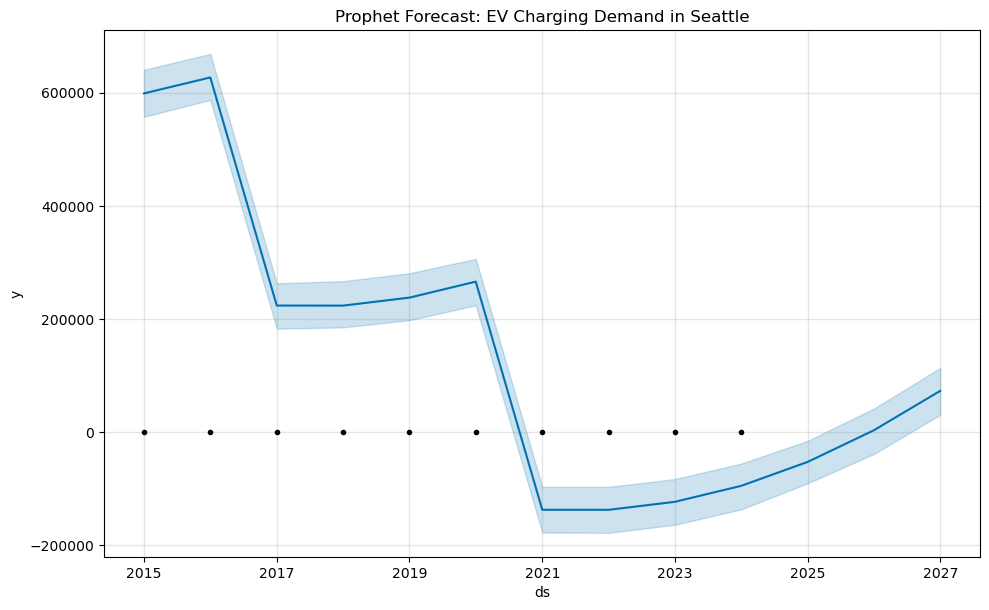

22:29:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet forecast for Seattle completed. See prophet_forecast_seattle.png


22:29:27 - cmdstanpy - INFO - Chain [1] done processing
22:29:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet RMSE for Seattle: 58304.08


22:29:28 - cmdstanpy - INFO - Chain [1] done processing


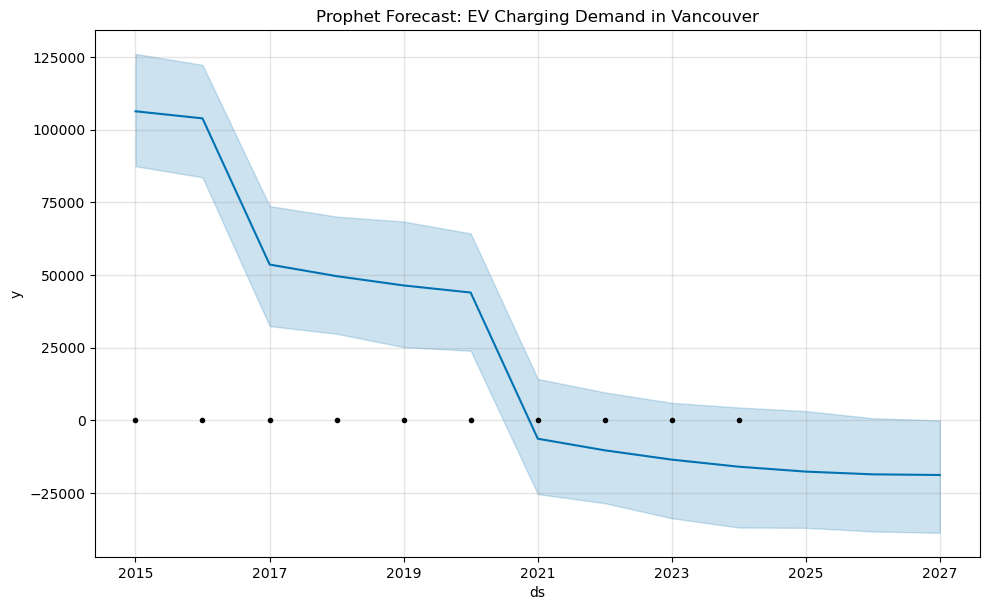

22:29:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet forecast for Vancouver completed. See prophet_forecast_vancouver.png


22:29:29 - cmdstanpy - INFO - Chain [1] done processing
22:29:29 - cmdstanpy - INFO - Chain [1] start processing
22:29:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for Vancouver: 5374.68


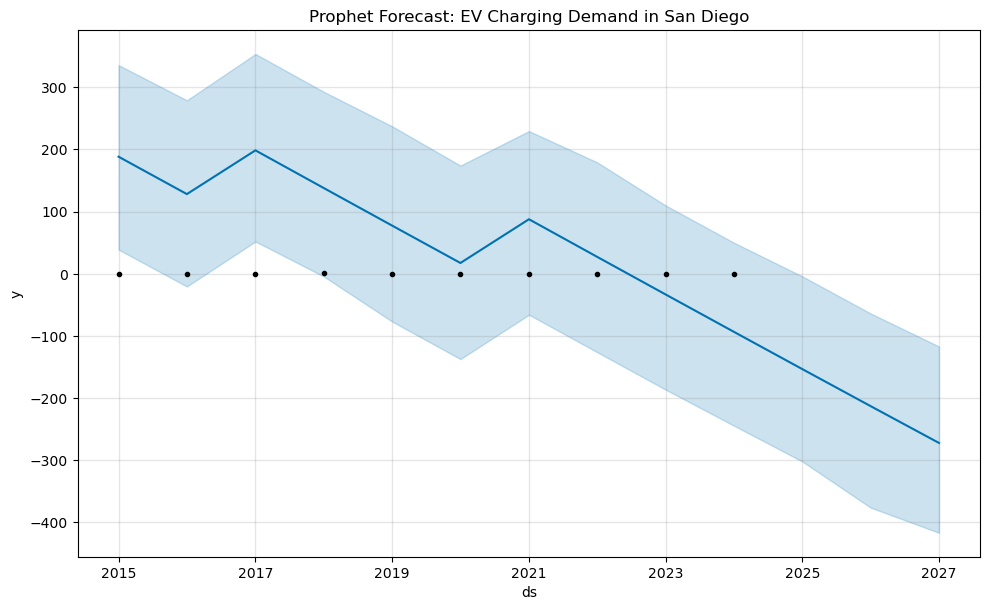

Prophet forecast for San Diego completed. See prophet_forecast_san_diego.png
Skipping Prophet validation for San Diego: Insufficient train/test data


In [45]:
# Step 7: Prophet Modeling
prophet_forecasts = {}
prophet_validation = {}
for city in cities_to_forecast:
    try:
        city_data = ev_timeseries[ev_timeseries['City'] == city][['Year', 'Weighted_Demand', 'temperature', 'humidity', 'traffic_volume']].copy()
        city_data['ds'] = pd.to_datetime(city_data['Year'].astype(str) + '-01-01')
        city_data['y'] = city_data['Weighted_Demand'] / 1000  # Scale to prevent numerical issues
        prophet_df = city_data[['ds', 'y', 'temperature', 'humidity', 'traffic_volume']].dropna()
        if len(prophet_df) < 3:
            print(f"Skipping Prophet for {city}: Insufficient data points")
            continue
        model = Prophet(yearly_seasonality=True)
        model.add_regressor('temperature')
        model.add_regressor('humidity')
        model.add_regressor('traffic_volume')
        model.fit(prophet_df)
        future = model.make_future_dataframe(periods=3, freq='Y')
        future['temperature'] = prophet_df['temperature'].mean()
        future['humidity'] = prophet_df['humidity'].mean()
        future['traffic_volume'] = prophet_df['traffic_volume'].mean()
        forecast = model.predict(future)
        forecast['yhat'] = forecast['yhat'] * 1000  # Rescale back
        forecast['yhat_lower'] = forecast['yhat_lower'] * 1000
        forecast['yhat_upper'] = forecast['yhat_upper'] * 1000
        prophet_forecasts[city] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        fig = model.plot(forecast)
        plt.title(f'Prophet Forecast: EV Charging Demand in {city}')
        plt.savefig(f'prophet_forecast_{city.lower().replace(" ", "_")}.png')
        plt.show()
        plt.close()
        print(f"Prophet forecast for {city} completed. See prophet_forecast_{city.lower().replace(' ', '_')}.png")
         # Validation
        train = prophet_df[prophet_df['ds'].dt.year <= 2022]  # Train on 2015-2022
        test = prophet_df[prophet_df['ds'].dt.year > 2022]   # Test on 2023-2024
        if len(train) < 3 or len(test) < 1 or test['y'].sum() == 0:
            print(f"Skipping Prophet validation for {city}: Insufficient train/test data")
            continue
        model = Prophet(yearly_seasonality=True)
        model.add_regressor('temperature')
        model.add_regressor('humidity')
        model.add_regressor('traffic_volume')
        model.fit(train)
        forecast = model.predict(test[['ds', 'temperature', 'humidity', 'traffic_volume']].reset_index(drop=True))
        rmse = ((forecast['yhat'] * 1000 - test['y'].reset_index(drop=True) * 1000) ** 2).mean() ** 0.5
        prophet_validation[city] = rmse
        print(f"Prophet RMSE for {city}: {rmse:.2f}")
    except Exception as e:
        print(f"Prophet error for {city}: {e}")

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 35: ARIMA Modeling 
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
• <b>Iterates</b> through <code>cities_to_forecast</code>.<br>
• <b>Prepares</b> data, scaling <code>Weighted_Demand</code> by 1000 and using temperature as an exogenous variable (except for San Diego due to sparse data).<br>
• <b>Visualizes</b> the time series and checks stationarity using the Augmented Dickey-Fuller (ADF) test.<br>
• <b>Applies differencing (d=1)</b> if non-stationary.<br>
• <b>Plots</b> differenced series, ACF, and PACF to determine ARIMA parameters (p, q).<br>
• <b>Performs grid search</b> over p=[0,1], d, q=[0,1] to select the best ARIMA model based on AIC.<br>
• <b>Evaluates</b> the model by plotting residuals and performing the Ljung-Box test.<br>
• <b>Conducts walk-forward cross-validation</b> (except for San Diego) to compute RMSE.<br>
• <b>Forecasts demand</b> for 2025–2027 and saves plots (e.g., <code>arima_forecast_seattle.png</code>).<br>
• <b>Stores results</b> in <code>arima_results</code>.<br>
• <b>Purpose</b>: Forecast EV charging demand using ARIMA and validate model performance.
</h4>


Building ARIMA model for Seattle


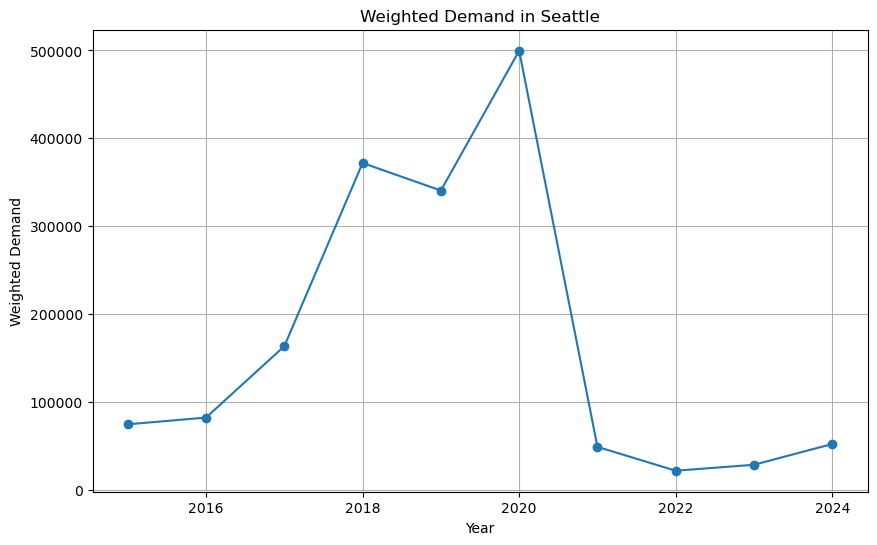


ADF Test for Seattle Weighted Demand:
ADF Statistic: -2.73
p-value: 0.0690
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}

ADF Test for Seattle Differenced (d=1):
ADF Statistic: -2.97
p-value: 0.0378
Critical Values: {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}


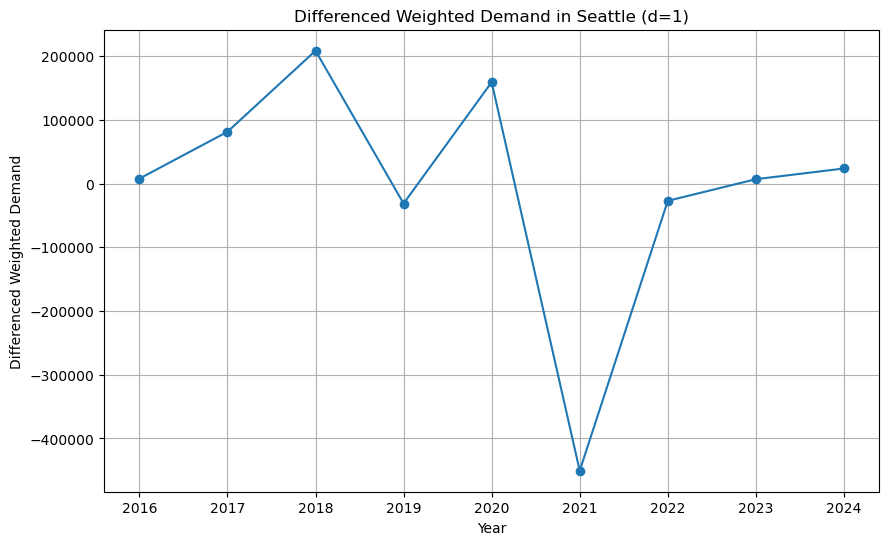

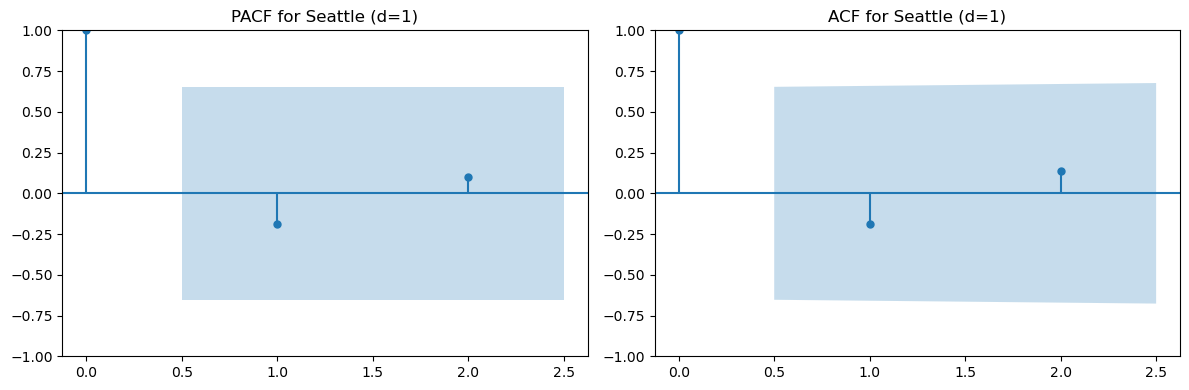

ARIMA(0, 1, 0) AIC: 121.22
ARIMA(0, 1, 1) AIC: 122.59
ARIMA(1, 1, 0) AIC: 122.63
ARIMA(1, 1, 1) AIC: 124.40

Best ARIMA model for Seattle: (0, 1, 0), AIC: 121.22


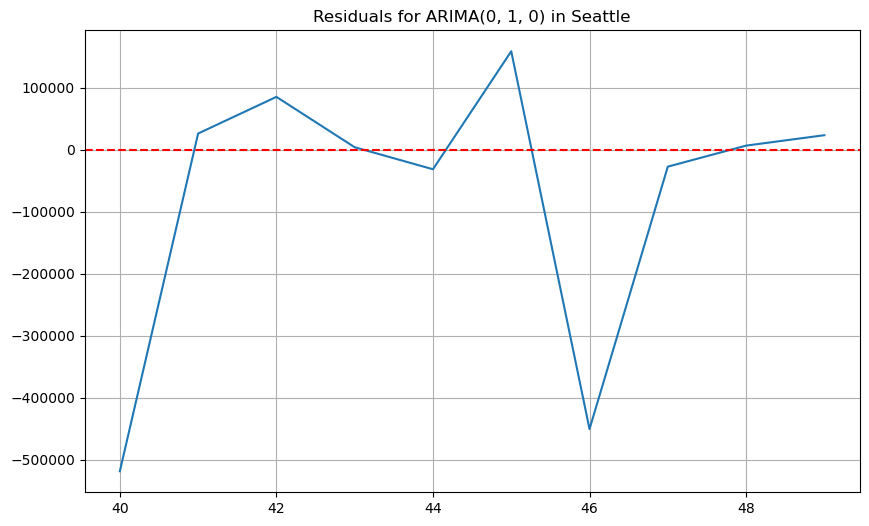


Ljung-Box Test for Seattle:
     lb_stat  lb_pvalue
3  1.079072   0.782128
ARIMA Cross-validation RMSE for Seattle: 17377.21


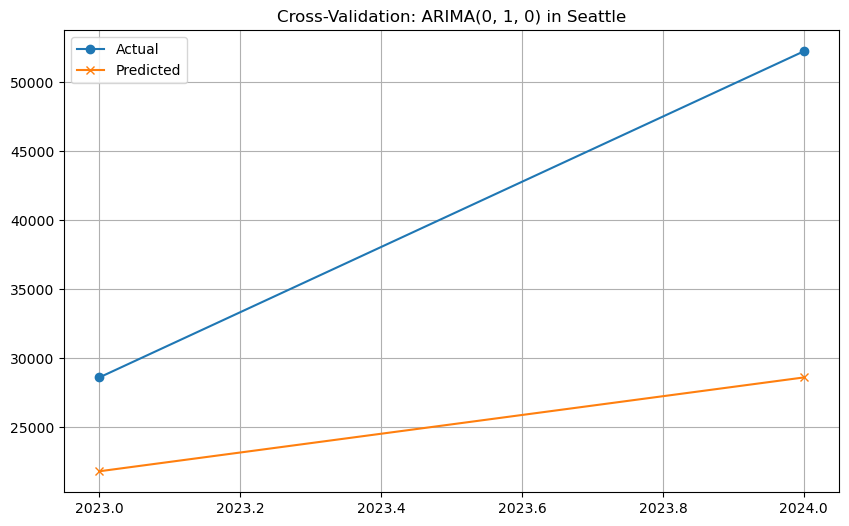

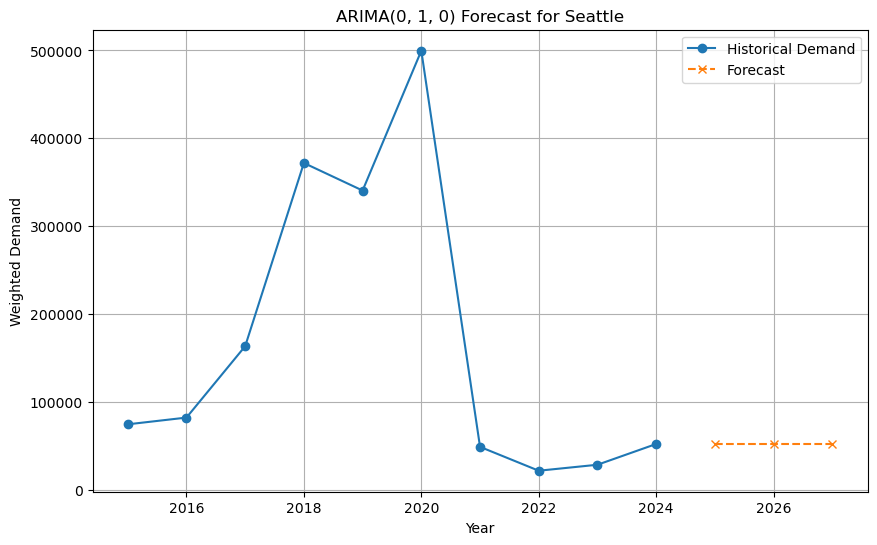


Building ARIMA model for Vancouver


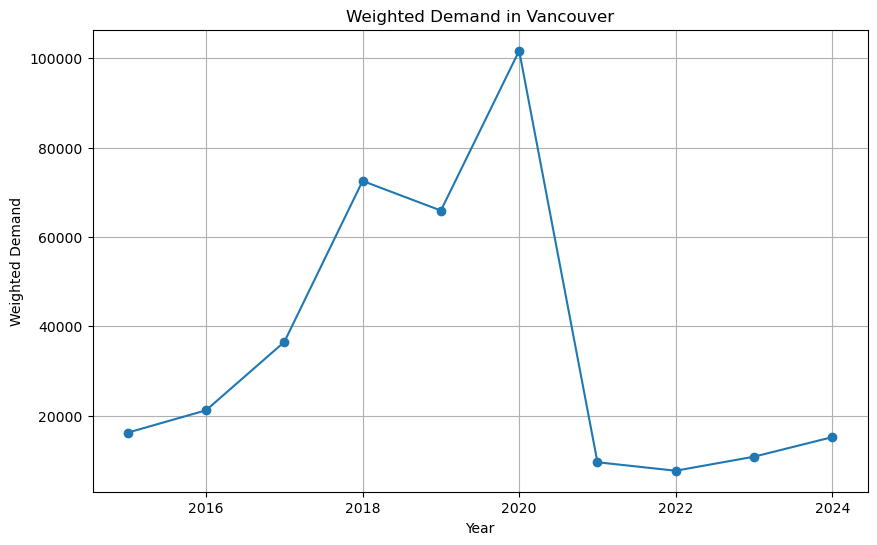


ADF Test for Vancouver Weighted Demand:
ADF Statistic: -2.14
p-value: 0.2302
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}

ADF Test for Vancouver Differenced (d=1):
ADF Statistic: -3.20
p-value: 0.0200
Critical Values: {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}


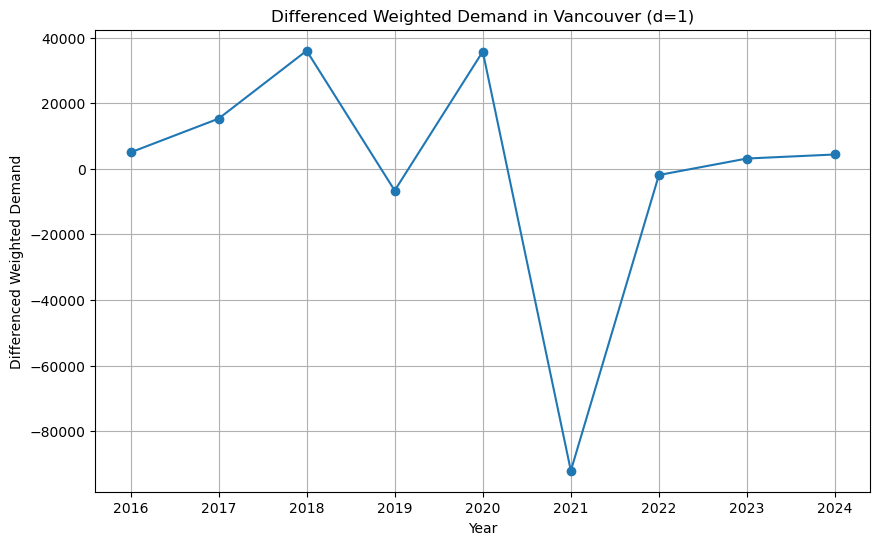

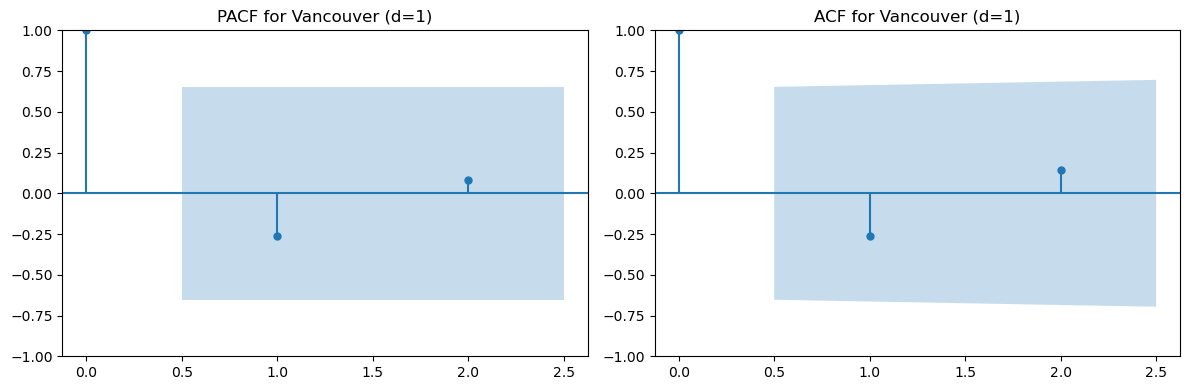

ARIMA(0, 1, 0) AIC: 92.67
ARIMA(0, 1, 1) AIC: 93.63
ARIMA(1, 1, 0) AIC: 93.74
ARIMA(1, 1, 1) AIC: 95.63

Best ARIMA model for Vancouver: (0, 1, 0), AIC: 92.67


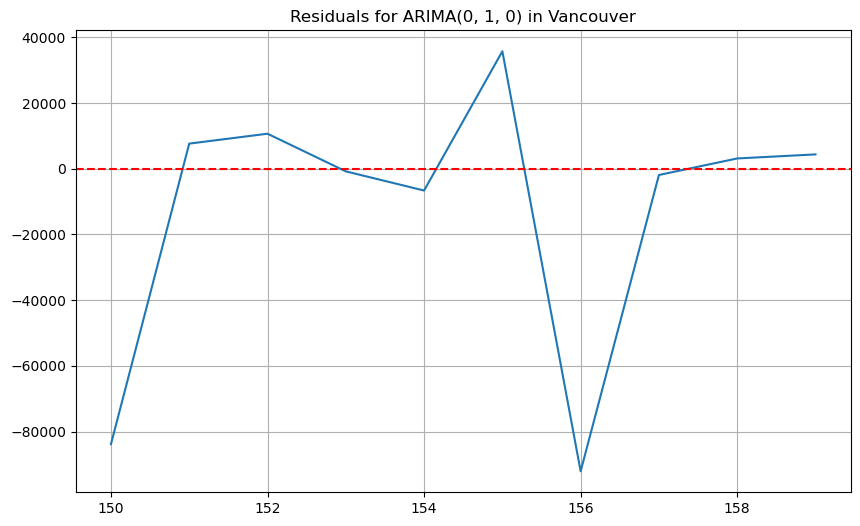


Ljung-Box Test for Vancouver:
     lb_stat  lb_pvalue
3  1.446334   0.694711
ARIMA Cross-validation RMSE for Vancouver: 3808.15


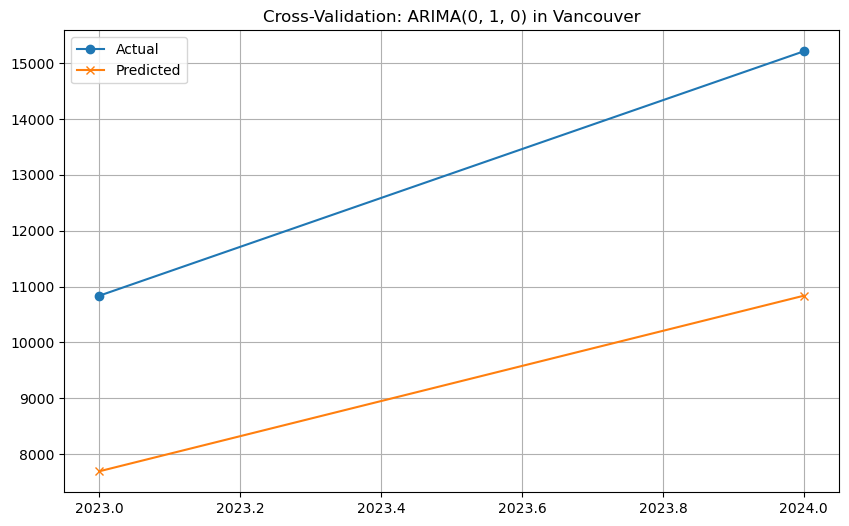

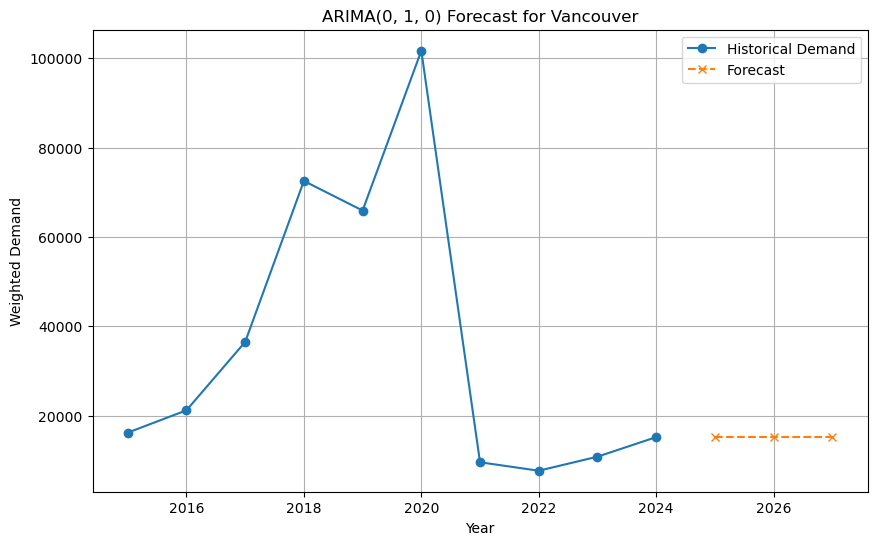


Building ARIMA model for San Diego


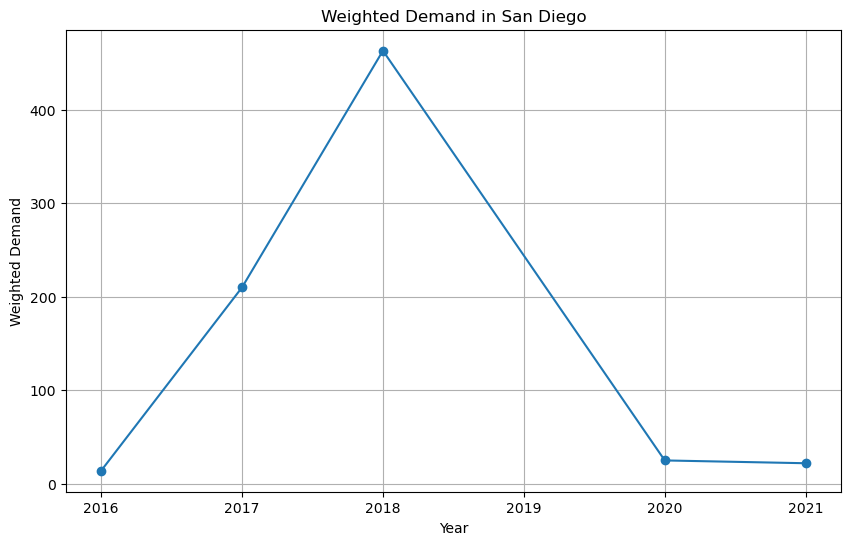

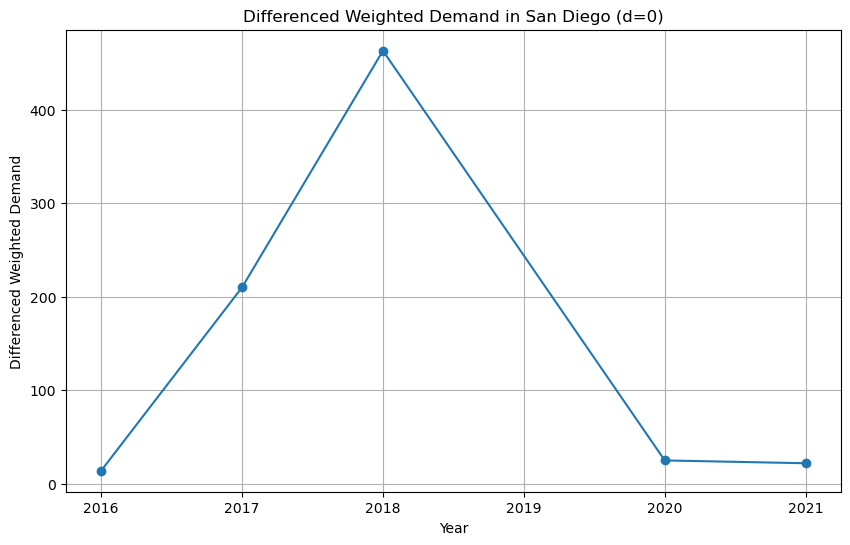

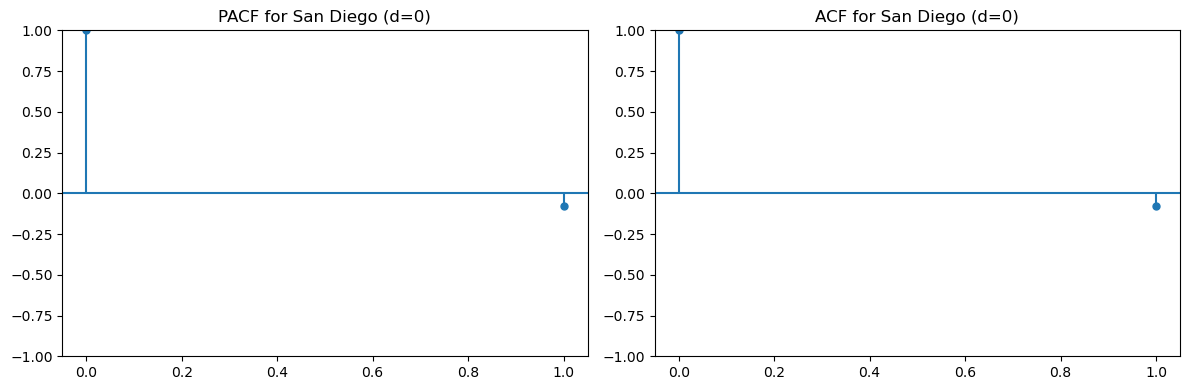

ARIMA(0, 0, 0) AIC: 0.72
ARIMA(0, 0, 1) AIC: 1.12
ARIMA(1, 0, 0) AIC: 2.69
ARIMA(1, 0, 1) AIC: 3.09

Best ARIMA model for San Diego: (0, 0, 0), AIC: 0.72


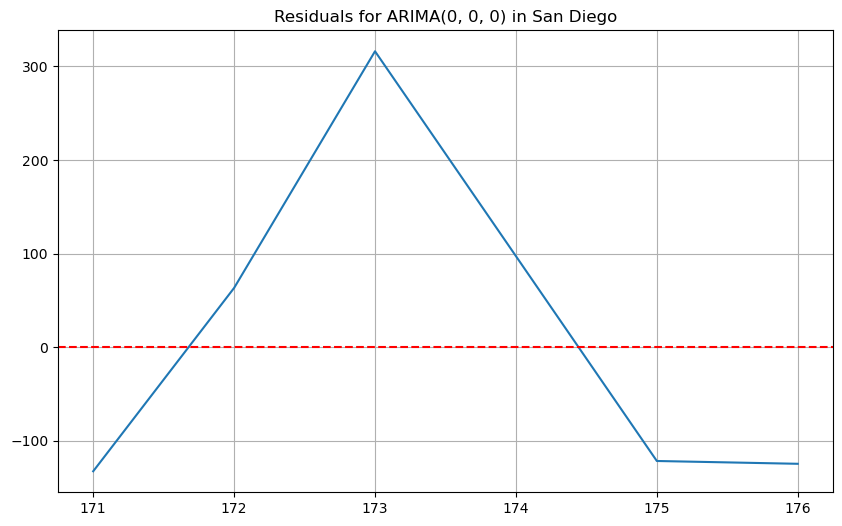


Ljung-Box Test for San Diego:
     lb_stat  lb_pvalue
3  4.116211   0.249186
Skipping ARIMA cross-validation for San Diego: Sparse data, relying on Prophet


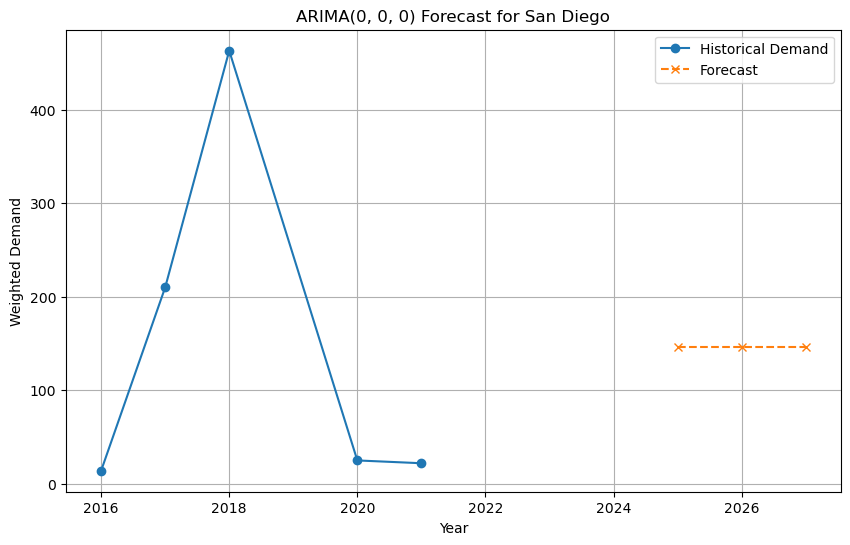

In [46]:
# Step 8: ARIMA Modeling
arima_results = {}
for city in cities_to_forecast:
    print(f"\nBuilding ARIMA model for {city}")
    city_data = ev_timeseries[ev_timeseries['City'] == city][['Year', 'Weighted_Demand', 'temperature']].copy()
    city_data = city_data[city_data['Weighted_Demand'] > 0].dropna()  # Filter non-zero demand
    if len(city_data) < 3:
        print(f"Skipping ARIMA for {city}: Insufficient non-zero data points ({len(city_data)})")
        continue
    
    # Extract time series
    ts = city_data['Weighted_Demand'] / 1000  # Scale to prevent numerical issues
    exog = city_data[['temperature']] if city != 'San Diego' else None  # No exog for San Diego
    
    # Visualize time series
    plt.figure(figsize=(10, 6))
    plt.plot(city_data['Year'], ts * 1000, marker='o')
    plt.title(f'Weighted Demand in {city}')
    plt.xlabel('Year')
    plt.ylabel('Weighted Demand')
    plt.grid(True)
    plt.savefig(f'weighted_demand_{city.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

    # Check Stationarity and Differencing
    def adf_test(series, title=''):
        result = adfuller(series.dropna())
        print(f'\nADF Test for {title}:')
        print(f'ADF Statistic: {result[0]:.2f}')
        print(f'p-value: {result[1]:.4f}')
        print(f'Critical Values: {result[4]}')
        return result[1] <= 0.05
    
    is_stationary = False
    d = 0
    differenced_ts = ts.copy()
    
    if len(ts) > 5:  # Only check stationarity for sufficient data
        is_stationary = adf_test(ts, f'{city} Weighted Demand')
        if not is_stationary and len(ts) >= 4:
            differenced_ts = ts.diff().dropna()
            d = 1
            if len(differenced_ts) >= 2:
                is_stationary = adf_test(differenced_ts, f'{city} Differenced (d={d})')
    
    plt.figure(figsize=(10, 6))
    plt.plot(city_data['Year'][d:], differenced_ts * 1000, marker='o')
    plt.title(f'Differenced Weighted Demand in {city} (d={d})')
    plt.xlabel('Year')
    plt.ylabel('Differenced Weighted Demand')
    plt.grid(True)
    plt.savefig(f'differenced_demand_{city.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

    # Determine p (AR) and q (MA) using PACF and ACF
    if len(differenced_ts) > 2:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plot_pacf(differenced_ts, lags=min(len(differenced_ts)//2-1, 2), ax=plt.gca())
        plt.title(f'PACF for {city} (d={d})')
        plt.subplot(122)
        plot_acf(differenced_ts, lags=min(len(differenced_ts)//2-1, 2), ax=plt.gca())
        plt.title(f'ACF for {city} (d={d})')
        plt.tight_layout()
        plt.savefig(f'acf_pacf_{city.lower().replace(" ", "_")}.png')
        plt.show()
        plt.close()

    # Model Selection (Grid Search)
    p_values = [0, 1]
    d_values = [d]
    q_values = [0, 1]
    pdq_combinations = list(itertools.product(p_values, d_values, q_values))
    
    best_aic = float('inf')
    best_order = None
    best_model = None
    
    for pdq in pdq_combinations:
        try:
            model = ARIMA(ts, order=pdq, exog=exog)
            results = model.fit()
            aic = results.aic
            print(f'ARIMA{pdq} AIC: {aic:.2f}')
            if aic < best_aic:
                best_aic = aic
                best_order = pdq
                best_model = results
        except:
            continue
    
    if best_model is None:
        print(f"No valid ARIMA model found for {city}")
        continue
    
    print(f"\nBest ARIMA model for {city}: {best_order}, AIC: {best_aic:.2f}")

    # Model Evaluation
    residuals = best_model.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals * 1000)
    plt.title(f'Residuals for ARIMA{best_order} in {city}')
    plt.axhline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.savefig(f'residuals_{city.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()
    
    lb_test = acorr_ljungbox(residuals, lags=[min(len(residuals)-1, 3)], return_df=True)
    print(f"\nLjung-Box Test for {city}:\n", lb_test)
    
    # Cross-validation (walk-forward)
    if city != 'San Diego':  # Skip cross-validation for San Diego due to sparse data
        train_size = int(len(ts) * 0.8) if len(ts) > 5 else len(ts) - 1
        train_ts, test_ts = ts[:train_size], ts[train_size:]
        train_exog = exog[:train_size] if exog is not None else None
        test_exog = exog[train_size:] if exog is not None else None
        
        if len(test_ts) >= 1:
            history_ts = train_ts.copy()
            history_exog = train_exog.copy() if exog is not None else None
            predictions = []
            
            for t in range(len(test_ts)):
                try:
                    model = ARIMA(history_ts, order=best_order, exog=history_exog)
                    model_fit = model.fit()
                    pred = model_fit.forecast(steps=1, exog=test_exog.iloc[t:t+1] if exog is not None else None)
                    predictions.append(pred.iloc[0])
                    history_ts = pd.concat([history_ts, test_ts.iloc[[t]]], ignore_index=True)
                    history_exog = pd.concat([history_exog, test_exog.iloc[[t]]] if exog is not None else None, ignore_index=True)
                except Exception as e:
                    print(f"Cross-validation error at step {t} for {city}: {e}")
                    predictions.append(np.nan)
            
            valid_preds = [p for p in predictions if not np.isnan(p)]
            valid_test = [t for p, t in zip(predictions, test_ts) if not np.isnan(p)]
            if valid_preds and len(valid_preds) == len(valid_test) and len(valid_test) == len(city_data['Year'][train_size:]):
                rmse = np.sqrt(((np.array(valid_preds) * 1000 - np.array(valid_test) * 1000) ** 2).mean())
                print(f"ARIMA Cross-validation RMSE for {city}: {rmse:.2f}")
                
                plt.figure(figsize=(10, 6))
                plt.plot(city_data['Year'][train_size:], np.array(valid_test) * 1000, label='Actual', marker='o')
                plt.plot(city_data['Year'][train_size:], np.array(valid_preds) * 1000, label='Predicted', marker='x')
                plt.title(f'Cross-Validation: ARIMA{best_order} in {city}')
                plt.legend()
                plt.grid(True)
                plt.savefig(f'cross_validation_{city.lower().replace(" ", "_")}.png')
                plt.show()
                plt.close()
            else:
                print(f"Skipping cross-validation plotting for {city}: Invalid or mismatched predictions")
                rmse = np.nan
        else:
            print(f"Skipping cross-validation for {city}: Insufficient test data")
            rmse = np.nan
    else:
        print(f"Skipping ARIMA cross-validation for {city}: Sparse data, relying on Prophet")
        rmse = np.nan

    # Forecasting
    exog_future = pd.concat([exog.iloc[-1:]] * 3, ignore_index=True) if exog is not None else None
    forecast = best_model.forecast(steps=3, exog=exog_future) * 1000  # Rescale back
    forecast_years = range(2025, 2028)
    
    plt.figure(figsize=(10, 6))
    plt.plot(city_data['Year'], ts * 1000, label='Historical Demand', marker='o')
    plt.plot(forecast_years, forecast, label='Forecast', marker='x', linestyle='--')
    plt.title(f'ARIMA{best_order} Forecast for {city}')
    plt.xlabel('Year')
    plt.ylabel('Weighted Demand')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'arima_forecast_{city.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()
    
    arima_results[city] = {
        'order': best_order,
        'aic': best_aic,
        'rmse': rmse,
        'forecast': forecast,
        'forecast_years': forecast_years
    }




 <h3 style="color:#0b3d91; font-weight:bold;">
Step 36: Save Prophet and ARIMA Forecasts
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
    • <b>Saves</b> Prophet forecasts (<code>prophet_forecasts</code>) as CSVs with columns <code>ds</code> (year), <code>yhat</code>, <code>yhat_lower</code>, <code>yhat_upper</code>.<br>
    • <b>Saves</b> ARIMA forecasts (<code>arima_results</code>) as CSVs with columns <code>Year</code> and <code>Forecast</code>.<br>
    • <b>Uses</b> <code>os.makedirs</code> to ensure the output directory exists.<br>
    • <b>Handles errors</b> to prevent crashes.<br>
    • <b>Purpose</b>: Persist forecast results for use in the Streamlit dashboard.
</h4>

In [ ]:
#Step 8.5: Save Prophet and ARIMA Forecasts
print("\nSaving forecast results to CSVs...")
DATA_PATH = r'D:\Internship\DataSet\Electrical_vehicle_'  # Fixed: Removed trailing backslash
os.makedirs(DATA_PATH, exist_ok=True)  # Ensure directory exists

# Save Prophet forecasts
for city, forecast in prophet_forecasts.items():
    try:
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        forecast_df['ds'] = forecast_df['ds'].dt.year  # Convert datetime to year
        forecast_file = os.path.join(DATA_PATH, f'prophet_forecast_{city.lower().replace(" ", "_")}.csv')
        forecast_df.to_csv(forecast_file, index=False)
        print(f"Saved Prophet forecast for {city} to {forecast_file}")
    except Exception as e:
        print(f"Error saving Prophet forecast for {city}: {e}")

# Save ARIMA forecasts
for city, result in arima_results.items():
    try:
        forecast_df = pd.DataFrame({
            'Year': result['forecast_years'],
            'Forecast': result['forecast']
        })
        forecast_file = os.path.join(DATA_PATH, f'arima_forecast_{city.lower().replace(" ", "_")}.csv')
        forecast_df.to_csv(forecast_file, index=False)
        print(f"Saved ARIMA forecast for {city} to {forecast_file}")
    except Exception as e:
        print(f"Error saving ARIMA forecast for {city}: {e}")
# Step 9: Export for Tableau/Excel
summary = merged_weather_ev.groupby(['City', 'State']).agg({
    'VIN (1-10)': 'count', 'temperature': 'mean', 'humidity': 'mean', 'Electric Range': 'mean'
}).rename(columns={'VIN (1-10)': 'EV_Count'}).reset_index()
summary.to_csv(tableau_file, index=False)
print(f"\nSummary for PowerBI saved to: {tableau_file}")



  <h3 style="color:#0b3d91; font-weight:bold;">
Step 37: Additional Visualizations
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
    • <b>Creates</b> a line plot of total <code>Weighted_Demand</code> by year.<br>
    • <b>Creates</b> a scatter plot of <code>Weighted_Demand</code> vs. temperature, colored by City.<br>
    • <b>Saves</b> plots as <code>ev_demand_trend.png</code> and <code>temperature_vs_demand.png</code>.<br>
    • <b>Purpose</b>: Generate visualizations to explore trends and relationships in the data.<br>
    • <b>Output</b>: PNG files saved in the working directory.
</h4>

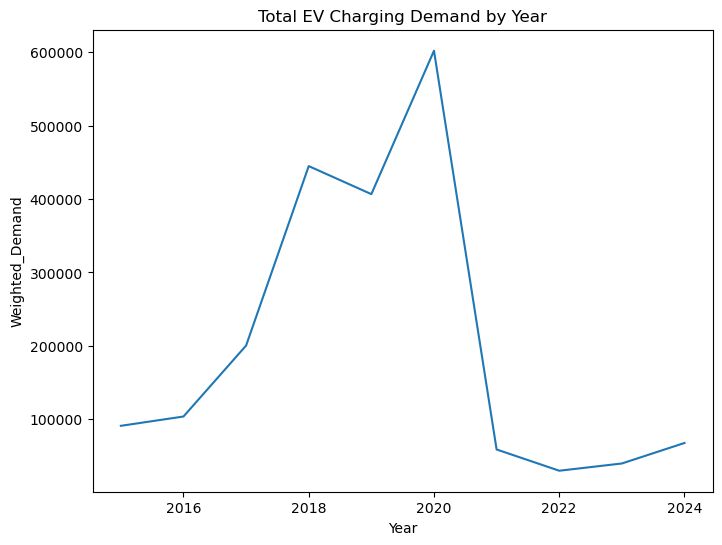

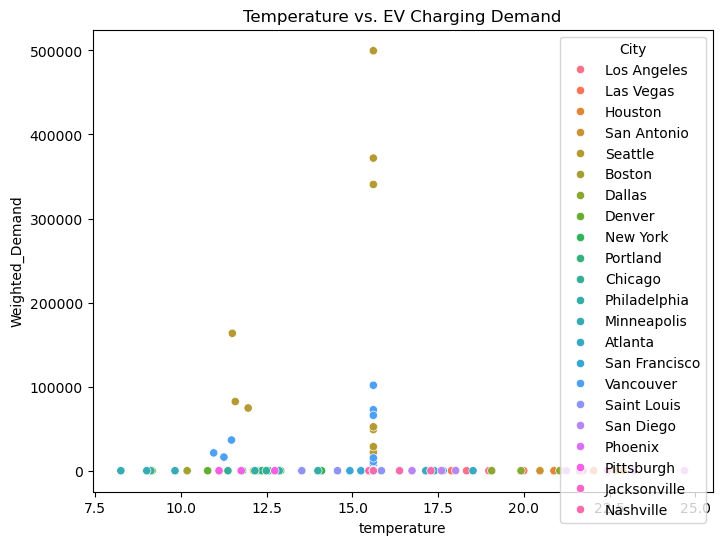

In [47]:
# Step 10: Additional visualizations
ev_yearly = ev_timeseries.groupby('Year')['Weighted_Demand'].sum().reset_index()
plt.figure(figsize=(8, 6))
sns.lineplot(data=ev_yearly, x='Year', y='Weighted_Demand')
plt.title('Total EV Charging Demand by Year')
plt.savefig('ev_demand_trend.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ev_timeseries, x='temperature', y='Weighted_Demand', hue='City')
plt.title('Temperature vs. EV Charging Demand')
plt.savefig('temperature_vs_demand.png')
plt.show()
plt.close()

 <h3 style="color:#0b3d91; font-weight:bold;">
Step 38: Generate Summary Report
</h3>

<h4 style="font-family:Arial, sans-serif; color:#333333; font-weight:normal; line-height:1.6;">
    • <b>Creates</b> a comprehensive report in <code>ev_forecast_report.txt</code>.<br>
    • <b>Includes</b> the following sections:<br>
        • <b>Date and data summary</b>: Overview of weather, EV, and time-series data.<br>
        • <b>Forecasting results</b> for Prophet and ARIMA (2025–2027).<br>
        • <b>Validation results</b>: RMSE for each model.<br>
        • <b>Model comparison</b>: Based on RMSE for evaluation of forecasting accuracy.<br>
        • <b>Recommendations</b> for charging station placement, derived from the analysis.<br>
        • <b>Limitations</b> of the analysis: E.g., sparse data, limited traffic data.<br>
    • <b>Purpose</b>: Summarize findings and provide actionable insights for stakeholders.<br>
    • <b>Output</b>: Summary report saved to: <code>D:...\ev_forecast_report.txt</code>.
</h4>

In [56]:
# Step 11: Generate summary report
with open(report_file, 'w') as f:
    f.write("Electric Vehicle Charging Demand Forecasting Report\n")
    f.write("==============================================\n\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n\n")
    f.write("Data Summary:\n")
    f.write(f"- Weather data: {weather_data.shape[0]} rows, {len(valid_cities)} cities\n")
    f.write(f"- EV data: {ev_data.shape[0]} rows, {len(common_cities)} common cities\n")
    f.write(f"- Time-series data: {ev_timeseries.shape[0]} rows, {len(cities_to_forecast)} cities forecasted\n\n")
    f.write("Forecasting Results:\n")
    for city in cities_to_forecast:
        if city in prophet_forecasts:
            f.write(f"{city} (Prophet):\n")
            for _, row in prophet_forecasts[city].tail(3).iterrows():
                f.write(f"  {row['ds'].year}: {row['yhat']:.2f} ({row['yhat_lower']:.2f} - {row['yhat_upper']:.2f})\n")
        if city in arima_results:
            f.write(f"{city} (ARIMA, Order {arima_results[city]['order']}):\n")
            for year, value in zip(arima_results[city]['forecast_years'], arima_results[city]['forecast']):
                f.write(f"  {year}: {value:.2f}\n")
    f.write("\nValidation Results:\n")
    for city in prophet_validation:
        f.write(f"{city} Prophet RMSE: {prophet_validation[city]:.2f}\n")
    for city in arima_results:
        if not np.isnan(arima_results[city]['rmse']):
            f.write(f"{city} ARIMA RMSE: {arima_results[city]['rmse']:.2f}\n")
    f.write("\nModel Comparison:\n")
    for city in cities_to_forecast:
        if city in prophet_validation and city in arima_results and not np.isnan(arima_results[city]['rmse']):
            prophet_rmse = prophet_validation.get(city, float('inf'))
            arima_rmse = arima_results[city]['rmse']
            f.write(f"- {city}: {'Prophet' if prophet_rmse < arima_rmse else 'ARIMA'} is better (Prophet RMSE: {prophet_rmse:.2f}, ARIMA RMSE: {arima_rmse:.2f})\n")
        elif city in prophet_validation:
            f.write(f"- {city}: Only Prophet RMSE available: {prophet_validation[city]:.2f}\n")
        elif city in arima_results and not np.isnan(arima_results[city]['rmse']):
            f.write(f"- {city}: Only ARIMA RMSE available: {arima_results[city]['rmse']:.2f}\n")
        else:
            f.write(f"- {city}: No validation available (sparse data)\n")
    f.write("\nRecommendations:\n")
    high_demand_cities = ev_timeseries.groupby('City')['Weighted_Demand'].sum().nlargest(3).index.tolist()
    f.write(f"- Prioritize charging station expansion in: {', '.join(high_demand_cities)}\n")
    f.write("- Install ~1 charging station per 10,000 units of Weighted_Demand.\n")
    f.write("- Monitor weather impacts (temperature, humidity) on demand.\n")
    f.write("- Use traffic data for station placement in high-traffic areas.\n")
    f.write("\nLimitations:\n")
    f.write("- Sparse EV data limited forecasting to few cities.\n")
    f.write("- Traffic data only available for Minneapolis.\n")
    f.write("- Short annual series (10 points) may affect model stability.\n")
print(f"Summary report saved to: {report_file}")

Summary report saved to: D:\Internship\DataSet\Electrical_vehicle_\ev_forecast_report.txt
